In [2]:
import re
import numpy as np
import pandas as pd


In [68]:
import os  

os.listdir("/Users/pavankumar/Downloads")  # List all files and folders in the Downloads directory




['IMG_1713.HEIC',
 'IMG_2095.HEIC',
 'IMG_2696.MOV',
 'IMG_7628.HEIC',
 'IMG_8027.HEIC',
 'IMG_1656.HEIC',
 'IMG_7501.heic',
 'IMG_5496.HEIC',
 '_DSC0835.JPG',
 'IMG_1590.HEIC',
 'mock-test-2-Pavan8765-1',
 'C7CF4E9A-6B67-4034-9C38-D817A317B60D.MP4',
 '_DSC0809.JPG',
 'IMG_1969.HEIC',
 'DEA_Solver_Project1_Setup.xlsx',
 'PPT1.pptx',
 'QEX383708684_auth_letter.pdf',
 '_DSC1040.JPG',
 'archive (1)',
 'BEMM464',
 'IMG_1744.HEIC',
 'IMG_1601.HEIC',
 '0C246061-526C-40EF-BB8D-66199F44C6C3.MP4',
 'IMG_5462.MOV',
 'IMG_1528.HEIC',
 'Project- Generic Example..pdf',
 'IMG_6157.MOV',
 'IMG_1894.HEIC',
 'Aadhar card.pdf',
 'IMG_2241.HEIC',
 'Final New Venture Creation 2.docx',
 'D219D4E8-DEA7-4279-89A1-60CC19A23A0B.MP4',
 'IMG_1752.HEIC',
 'googlechrome.dmg',
 '53FA41FF-23BF-4205-AF23-AB34F35A9F70.JPG',
 'JANUARY.pages',
 'IMG_7498.MOV',
 'IMG_1617.HEIC',
 'IMG_5087.HEIC',
 'IMG_2742.HEIC',
 'IMG_2245.MOV',
 '058903_Xac94d503_1_318.docx',
 'IMG_7329.MOV',
 'IMG_1882.HEIC',
 'shashanktcs.pdf',
 'IM

In [70]:
os.listdir("/Users/pavankumar/Downloads/Dataset")  # Display all files and folders inside the Dataset directory



['database.sqlite',
 'tweets_cleaned.csv',
 'hourly_features.csv',
 'anomaly_results_hourly.csv',
 'Tweets.csv']

In [64]:
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"  # Store the file path of the CSV dataset

df_raw = pd.read_csv(DATA_PATH)  # Read the CSV file into a pandas DataFrame
print("Raw shape:", df_raw.shape)  # Print the number of rows and columns in the dataset

df_raw.head()  # Display the first few rows of the dataset



Raw shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [92]:
df = df_raw.copy()

# standardize column names
df.columns = df.columns.str.strip().str.lower()

# rename common columns to consistent schema
df = df.rename(columns={
    "text": "tweet_text",
    "tweet_created": "tweet_created_at",
    "created_at": "tweet_created_at",
    "negativereason": "negative_reason",
    "negativereason_confidence": "negative_reason_confidence",
    "user_timezone": "tweet_timezone",
})

print("Columns:", df.columns.tolist())


Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negative_reason', 'negative_reason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_text', 'tweet_coord', 'tweet_created_at', 'tweet_location', 'tweet_timezone']


In [94]:
# keep only rows that can be used in time series + modelling
critical = [c for c in ["tweet_text", "tweet_created_at", "airline", "airline_sentiment"] if c in df.columns]
df = df.dropna(subset=critical).copy()

print("After dropping missing critical fields:", df.shape)


After dropping missing critical fields: (14640, 15)


In [108]:
# Convert tweet_created_at column to datetime format
df["tweet_created_at"] = pd.to_datetime(df["tweet_created_at"], errors="coerce", utc=True)

# Remove rows where tweet_created_at could not be converted
df = df.dropna(subset=["tweet_created_at"]).copy()

# Sort the data by airline and tweet creation time
df = df.sort_values(["airline", "tweet_created_at"]).reset_index(drop=True)

# Extract hour from tweet creation time
df["hour"] = df["tweet_created_at"].dt.hour

# Extract day of the week from tweet creation time
df["dayofweek"] = df["tweet_created_at"].dt.dayofweek

# Extract date from tweet creation time
df["date"] = df["tweet_created_at"].dt.date

# Print the shape of the dataset after processing timestamps
print("After timestamp parse:", df.shape)


After timestamp parse: (14640, 18)


In [112]:
# Compile a regex pattern to remove URLs
URL_RE = re.compile(r"https?://\S+|www\.\S+")

# Compile a regex pattern to remove user mentions
MENTION_RE = re.compile(r"@\w+")

# Compile a regex pattern to remove non-alphanumeric characters (except spaces and hashtags)
NON_TEXT_RE = re.compile(r"[^a-zA-Z0-9\s#]")

# Define a function to clean tweet text
def clean_text(t: str) -> str:
    
    # Convert text to lowercase and ensure it is a string
    t = str(t).lower()
    
    # Replace HTML encoded ampersand with word 'and'
    t = t.replace("&amp;", "and")
    
    # Remove URLs from the text
    t = URL_RE.sub(" ", t)
    
    # Remove user mentions from the text
    t = MENTION_RE.sub(" ", t)
    
    # Remove hashtag symbol but keep the hashtag words
    t = t.replace("#", " ")
    
    # Remove remaining non-text characters
    t = NON_TEXT_RE.sub(" ", t)
    
    # Remove extra spaces and trim text
    t = re.sub(r"\s+", " ", t).strip()
    
    # Return cleaned text
    return t

# Apply text cleaning function to the tweet_text column
df["tweet_text_clean"] = df["tweet_text"].apply(clean_text)

# Remove rows where cleaned text is empty
df = df[df["tweet_text_clean"].str.len() > 0].copy()

# Print dataset shape after text cleaning
print("After text cleaning:", df.shape)


After text cleaning: (14640, 19)


In [114]:
# Define a function to extract hashtags from tweet text
def extract_hashtags(t: str):
    return re.findall(r"#(\w+)", str(t).lower())

# Define a function to extract user mentions from tweet text
def extract_mentions(t: str):
    return re.findall(r"@(\w+)", str(t).lower())

# Extract hashtags from the original tweet text
df["hashtags"] = df["tweet_text"].apply(extract_hashtags)

# Extract user mentions from the original tweet text
df["mentions"] = df["tweet_text"].apply(extract_mentions)

# Count the number of hashtags in each tweet
df["hashtag_count"] = df["hashtags"].apply(len)

# Count the number of mentions in each tweet
df["mention_count"] = df["mentions"].apply(len)


In [116]:
# Check if retweet_count column exists
if "retweet_count" in df.columns:
    
    # Convert retweet_count to numeric values and replace missing values with 0
    df["retweet_count"] = (
        pd.to_numeric(df["retweet_count"], errors="coerce")
        .fillna(0)
        .astype(int)
    )

# Check if airline_sentiment_confidence column exists
if "airline_sentiment_confidence" in df.columns:
    
    # Convert airline_sentiment_confidence to numeric format
    df["airline_sentiment_confidence"] = pd.to_numeric(
        df["airline_sentiment_confidence"], errors="coerce"
    )

# Print the final shape of the cleaned dataset
print("Final cleaned shape:", df.shape)

# Display the count of each airline sentiment category
print(df["airline_sentiment"].value_counts())


Final cleaned shape: (14640, 23)
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [118]:
# Define the output file path for the cleaned dataset
OUT_PATH = "/Users/pavankumar/Downloads/Dataset/tweets_cleaned.csv"

# Save the cleaned DataFrame to a CSV file without row indices
df.to_csv(OUT_PATH, index=False)

# Confirm that the cleaned file has been saved
print("Saved cleaned file to:", OUT_PATH)


Saved cleaned file to: /Users/pavankumar/Downloads/Dataset/tweets_cleaned.csv


In [120]:
# Convert tweet_created_at to datetime format and remove invalid timestamps
df["tweet_created_at"] = pd.to_datetime(df["tweet_created_at"], utc=True, errors="coerce")
df = df.dropna(subset=["tweet_created_at"]).copy()

# Round timestamps down to the nearest hour for time-based aggregation
df["hour_ts"] = df["tweet_created_at"].dt.floor("H")

# Create a binary column indicating negative sentiment
df["is_negative"] = (df["airline_sentiment"].str.lower() == "negative").astype(int)

# Aggregate tweet data per airline per hour
hourly = (
    df.groupby(["airline", "hour_ts"])
      .agg(
          # Total number of tweets in each hour
          tweet_volume=("tweet_text_clean", "size"),
          
          # Number of negative tweets in each hour
          neg_volume=("is_negative", "sum"),
          
          # Average retweet count (if available)
          avg_retweets=("retweet_count", "mean") if "retweet_count" in df.columns else ("is_negative", "mean"),
          
          # Average sentiment confidence (if available)
          avg_conf=("airline_sentiment_confidence", "mean") if "airline_sentiment_confidence" in df.columns else ("is_negative", "mean"),
          
          # Average number of hashtags per tweet
          hashtag_rate=("hashtag_count", "mean"),
          
          # Average number of mentions per tweet
          mention_rate=("mention_count", "mean"),
      )
      .reset_index()
)

# Calculate the proportion of negative tweets per hour
hourly["neg_rate"] = hourly["neg_volume"] / hourly["tweet_volume"]

# Display the first few rows of the aggregated dataset
hourly.head()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/3559129736.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour_ts"] = df["tweet_created_at"].dt.floor("H")


,airline,hour_ts,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate
0,American,2015-02-19 04:00:00+00:00,1,1,0.0,0.924000,0.00,1.0,1.0
1,American,2015-02-19 23:00:00+00:00,1,0,0.0,0.624200,0.00,1.0,0.0
2,American,2015-02-20 17:00:00+00:00,1,1,0.0,1.000000,0.00,1.0,1.0
3,American,2015-02-21 08:00:00+00:00,1,1,0.0,1.000000,0.00,1.0,1.0
4,American,2015-02-22 19:00:00+00:00,4,2,0.0,0.919275,0.25,1.0,0.5


In [122]:
# Define a function to fill missing hourly time slots for each airline
def fill_missing_hours(g):
    
    # Set hour_ts as index and sort by time
    g = g.set_index("hour_ts").sort_index()
    
    # Create a complete hourly time range between first and last timestamp
    full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
    
    # Reindex the DataFrame to include missing hours
    g = g.reindex(full_idx)
    g.index.name = "hour_ts"

    # Fill airline label for newly created rows
    g["airline"] = g["airline"].iloc[0] if "airline" in g.columns else None
    g["airline"] = g["airline"].ffill().bfill()

    # Fill missing tweet and negative tweet counts with 0
    for c in ["tweet_volume", "neg_volume"]:
        if c in g.columns:
            g[c] = g[c].fillna(0)

    # Fill missing rate and average values with 0 for hours with no tweets
    for c in ["avg_retweets", "avg_conf", "hashtag_rate", "mention_rate", "neg_rate"]:
        if c in g.columns:
            g[c] = g[c].fillna(0)

    # Return DataFrame with reset index
    return g.reset_index()

# Apply missing-hour filling for each airline
hourly_full = (
    hourly.groupby("airline", group_keys=False)
          .apply(fill_missing_hours)
          .reset_index(drop=True)
)

# Display the first few rows of the completed hourly dataset
hourly_full.head()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/4253853441.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/4253853441.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/4253853441.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/4253853441.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index

,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0


In [124]:
# Define a function to add rolling (moving window) features for each airline
def add_rolling_features(g, window=24):
    
    # Sort data by time to ensure rolling calculations are correct
    g = g.sort_values("hour_ts").copy()

    # Create rolling mean, rolling standard deviation, and z-score features
    for col in ["tweet_volume", "neg_rate", "avg_retweets", "hashtag_rate"]:
        if col in g.columns:
            
            # Calculate rolling mean for the selected column
            mu = g[col].rolling(window=window, min_periods=max(5, window//4)).mean()
            
            # Calculate rolling standard deviation for the selected column
            sd = g[col].rolling(window=window, min_periods=max(5, window//4)).std()
            
            # Store rolling mean in a new column
            g[f"{col}_roll_mean"] = mu
            
            # Store rolling std (replace 0 with NaN to avoid division errors)
            g[f"{col}_roll_std"] = sd.replace(0, np.nan)
            
            # Compute z-score to measure how unusual the current value is
            g[f"{col}_z"] = (g[col] - mu) / g[f"{col}_roll_std"]
            
            # Replace infinite values and fill missing values with 0
            g[f"{col}_z"] = g[f"{col}_z"].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Calculate hour-to-hour change in negative rate
    g["neg_rate_diff"] = g["neg_rate"].diff().fillna(0)

    # Return updated DataFrame with rolling features
    return g

# Add rolling features for each airline group
features_hourly = (
    hourly_full.groupby("airline", group_keys=False)
               .apply(add_rolling_features)
               .reset_index(drop=True)
)

# Display the first few rows of the feature dataset
features_hourly.head()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/3013378920.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_rolling_features)


,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate,tweet_volume_roll_mean,...,neg_rate_roll_mean,neg_rate_roll_std,neg_rate_z,avg_retweets_roll_mean,avg_retweets_roll_std,avg_retweets_z,hashtag_rate_roll_mean,hashtag_rate_roll_std,hashtag_rate_z,neg_rate_diff
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,-1.0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [126]:
# Define the output file path for the hourly feature dataset
OUT_FEATURE_PATH = "/Users/pavankumar/Downloads/Dataset/hourly_features.csv"

# Save the hourly feature DataFrame to a CSV file without row indices
features_hourly.to_csv(OUT_FEATURE_PATH, index=False)

# Confirm that the hourly feature file has been saved
print("Saved hourly feature table to:", OUT_FEATURE_PATH)

# Print the shape of the final feature dataset
print("Shape:", features_hourly.shape)


Saved hourly feature table to: /Users/pavankumar/Downloads/Dataset/hourly_features.csv
Shape: (1027, 22)


In [128]:
# Identify the top spikes based on negative-rate z-score
top_anoms = (
    features_hourly.sort_values("neg_rate_z", ascending=False)
    
    # Select relevant columns for anomaly inspection
    .loc[:, ["airline", "hour_ts", "tweet_volume", "neg_rate", "neg_rate_z", "tweet_volume_z"]]
    
    # Keep only the top 15 highest anomaly scores
    .head(15)
)

# Display the top negative sentiment spikes
top_anoms


,airline,hour_ts,tweet_volume,neg_rate,neg_rate_z,tweet_volume_z
37,American,2015-02-20 17:00:00+00:00,1.0,1.000000,4.694855,3.246793
87,American,2015-02-22 19:00:00+00:00,4.0,0.500000,4.694855,4.694855
88,American,2015-02-22 20:00:00+00:00,101.0,0.742574,3.858852,4.691172
52,American,2015-02-21 08:00:00+00:00,1.0,1.000000,3.246793,3.246793
89,American,2015-02-22 21:00:00+00:00,109.0,0.788991,3.018933,3.377997
870,Virgin America,2015-02-18 07:00:00+00:00,1.0,1.000000,2.771554,-0.737047
90,American,2015-02-22 22:00:00+00:00,103.0,0.864078,2.641947,2.549914
416,Southwest,2015-02-21 11:00:00+00:00,4.0,1.000000,2.535019,-1.058456
483,Southwest,2015-02-24 06:00:00+00:00,1.0,1.000000,2.486824,-1.239646
391,Southwest,2015-02-20 10:00:00+00:00,1.0,1.000000,2.451517,-1.089294


In [130]:
# Define the file path for the hourly features dataset
FEATURE_PATH = "/Users/pavankumar/Downloads/Dataset/hourly_features.csv"

# Load the hourly features CSV file into a DataFrame
features_hourly = pd.read_csv(FEATURE_PATH)

# Convert hour_ts column to datetime format
features_hourly["hour_ts"] = pd.to_datetime(
    features_hourly["hour_ts"], utc=True, errors="coerce"
)

# Remove rows with invalid or missing timestamps
features_hourly = features_hourly.dropna(subset=["hour_ts"]).copy()

# Print the shape of the dataset
print(features_hourly.shape)

# Display the first few rows of the dataset
features_hourly.head()


(1027, 22)


,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate,tweet_volume_roll_mean,...,neg_rate_roll_mean,neg_rate_roll_std,neg_rate_z,avg_retweets_roll_mean,avg_retweets_roll_std,avg_retweets_z,hashtag_rate_roll_mean,hashtag_rate_roll_std,hashtag_rate_z,neg_rate_diff
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,-1.0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [132]:
# Import NumPy for numerical operations
import numpy as np

# Define a list of candidate feature columns for modeling
candidate_features = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]

# Keep only the feature columns that exist in the dataset
feature_cols = [c for c in candidate_features if c in features_hourly.columns]

# Display the final list of features being used
print("Using features:", feature_cols)

# Create the feature matrix and handle infinite and missing values
X = (
    features_hourly[feature_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)


Using features: ['tweet_volume', 'neg_rate', 'avg_retweets', 'hashtag_rate', 'mention_rate', 'tweet_volume_z', 'neg_rate_z', 'avg_retweets_z', 'hashtag_rate_z', 'neg_rate_diff']


In [134]:
# Import StandardScaler for feature standardization
from sklearn.preprocessing import StandardScaler

# Initialize the standard scaler
scaler = StandardScaler()

# Standardize the feature matrix (mean = 0, standard deviation = 1)
X_scaled = scaler.fit_transform(X)


In [136]:
# Import Isolation Forest for anomaly detection
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
# contamination represents the expected proportion of anomalies
iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)

# Fit the model on the scaled feature matrix
iso.fit(X_scaled)

# Compute anomaly scores (lower values indicate more anomalous points)
features_hourly["if_score"] = iso.decision_function(X_scaled)

# Create a binary anomaly flag (1 = anomaly, 0 = normal)
features_hourly["if_anomaly"] = (iso.predict(X_scaled) == -1).astype(int)


In [138]:
# Import One-Class SVM for anomaly detection
from sklearn.svm import OneClassSVM

# Initialize the One-Class SVM model
# nu controls the expected proportion of anomalies
oc = OneClassSVM(kernel="rbf", nu=0.02, gamma="scale")

# Fit the model on the scaled feature matrix
oc.fit(X_scaled)

# Compute anomaly scores (higher values indicate more normal behavior)
features_hourly["oc_score"] = oc.decision_function(X_scaled)

# Create a binary anomaly flag (1 = anomaly, 0 = normal)
features_hourly["oc_anomaly"] = (oc.predict(X_scaled) == -1).astype(int)


In [140]:
# Create a combined anomaly flag where both models agree
features_hourly["both_anomaly"] = (
    (features_hourly["if_anomaly"] == 1) &
    (features_hourly["oc_anomaly"] == 1)
).astype(int)

# Print the number of anomalies detected by Isolation Forest
print("Isolation Forest anomalies:", features_hourly["if_anomaly"].sum())

# Print the number of anomalies detected by One-Class SVM
print("One-Class SVM anomalies:", features_hourly["oc_anomaly"].sum())

# Print the number of anomalies where both models agree
print("Both models agree anomalies:", features_hourly["both_anomaly"].sum())


Isolation Forest anomalies: 21
One-Class SVM anomalies: 68
Both models agree anomalies: 11


In [142]:
# Define the output file path for the anomaly detection results
OUT_ANOM_PATH = "/Users/pavankumar/Downloads/Dataset/anomaly_results_hourly.csv"

# Save the anomaly results DataFrame to a CSV file without row indices
features_hourly.to_csv(OUT_ANOM_PATH, index=False)

# Confirm that the anomaly results file has been saved
print("Saved anomaly results to:", OUT_ANOM_PATH)


Saved anomaly results to: /Users/pavankumar/Downloads/Dataset/anomaly_results_hourly.csv


In [144]:
# Identify the top anomalies based on Isolation Forest score
top_if = (
    features_hourly.sort_values("if_score", ascending=True)
    
    # Select relevant columns for anomaly analysis
    .loc[:, [
        "airline", "hour_ts", "tweet_volume", "neg_rate",
        "tweet_volume_z", "neg_rate_z",
        "if_score", "if_anomaly",
        "oc_score", "oc_anomaly",
        "both_anomaly"
    ]]
    
    # Keep the top 25 most anomalous observations
    .head(25)
)

# Display the top Isolation Forest anomalies
top_if


,airline,hour_ts,tweet_volume,neg_rate,tweet_volume_z,neg_rate_z,if_score,if_anomaly,oc_score,oc_anomaly,both_anomaly
304,Delta,2015-02-24 07:00:00+00:00,1.0,0.000000,-0.750797,-1.290158,-0.102777,1,0.000281,0,0
874,Virgin America,2015-02-18 11:00:00+00:00,1.0,0.000000,-0.642620,-0.725400,-0.090259,1,-0.000289,1,1
922,Virgin America,2015-02-20 11:00:00+00:00,1.0,0.000000,-0.869210,-0.744456,-0.085131,1,0.000191,0,0
88,American,2015-02-22 20:00:00+00:00,101.0,0.742574,4.691172,3.858852,-0.076288,1,0.000425,0,0
343,Southwest,2015-02-18 10:00:00+00:00,1.0,0.000000,-0.983772,-1.901051,-0.061396,1,0.000004,0,0
90,American,2015-02-22 22:00:00+00:00,103.0,0.864078,2.549914,2.641947,-0.045365,1,0.000429,0,0
89,American,2015-02-22 21:00:00+00:00,109.0,0.788991,3.377997,3.018933,-0.044800,1,-0.000241,1,1
219,Delta,2015-02-20 18:00:00+00:00,17.0,0.058824,0.784369,-1.121185,-0.044260,1,-0.000025,1,1
514,US Airways,2015-02-18 04:00:00+00:00,20.0,0.850000,0.294031,0.557813,-0.035114,1,0.000324,0,0
911,Virgin America,2015-02-20 00:00:00+00:00,2.0,0.000000,-0.250016,-0.708656,-0.030340,1,0.000114,0,0


In [56]:
top_both = (
    features_hourly[features_hourly["both_anomaly"] == 1]
    .sort_values("if_score", ascending=True)
    .loc[:, ["airline", "hour_ts", "tweet_volume", "neg_rate", "tweet_volume_z", "neg_rate_z",
             "if_score", "oc_score"]]
    .head(25)
)

top_both


,airline,hour_ts,tweet_volume,neg_rate,tweet_volume_z,neg_rate_z,if_score,oc_score
304,Delta,2015-02-24 07:00:00+00:00,1.0,0.000000,-0.750797,-1.290158,-0.103607,-0.000001
88,American,2015-02-22 20:00:00+00:00,99.0,0.747475,4.691022,3.867304,-0.073628,-0.000270
219,Delta,2015-02-20 18:00:00+00:00,17.0,0.058824,0.784369,-1.121185,-0.047859,-0.000327
979,Virgin America,2015-02-22 20:00:00+00:00,4.0,0.500000,0.441342,0.319908,-0.029931,-0.000193
291,Delta,2015-02-23 18:00:00+00:00,65.0,0.307692,3.120443,-0.777066,-0.023314,-0.000044
367,Southwest,2015-02-19 10:00:00+00:00,1.0,0.000000,-1.061414,-1.285777,-0.012942,-0.000206
436,Southwest,2015-02-22 07:00:00+00:00,2.0,0.500000,-1.336495,-0.859998,-0.011954,-0.000209
87,American,2015-02-22 19:00:00+00:00,4.0,0.500000,4.694855,4.694855,-0.010755,-0.000213
322,Southwest,2015-02-17 13:00:00+00:00,1.0,1.000000,0.221404,0.847579,-0.002121,-0.000044


In [146]:
# Print the shape of the final hourly feature dataset
print(features_hourly.shape)

# Print the number of anomalies detected by Isolation Forest
print("IF anomalies:", features_hourly["if_anomaly"].sum())

# Print the number of anomalies detected by One-Class SVM
print("OC anomalies:", features_hourly["oc_anomaly"].sum())

# Print the number of anomalies where both models agree
print("Both anomalies:", features_hourly["both_anomaly"].sum())


(1027, 27)
IF anomalies: 21
OC anomalies: 68
Both anomalies: 11


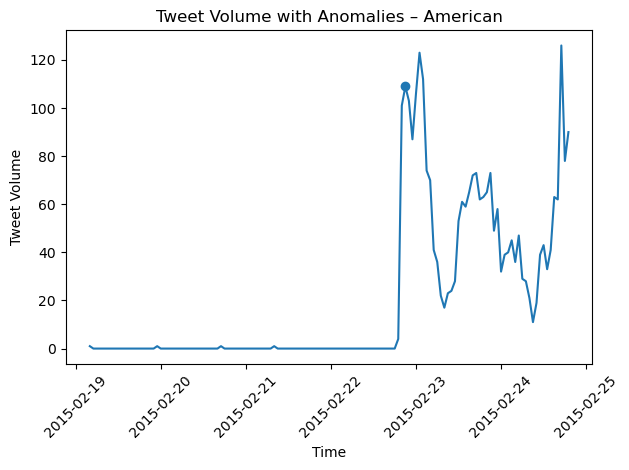

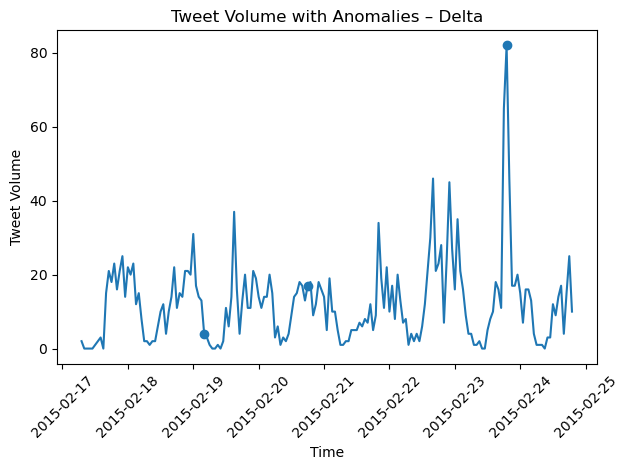

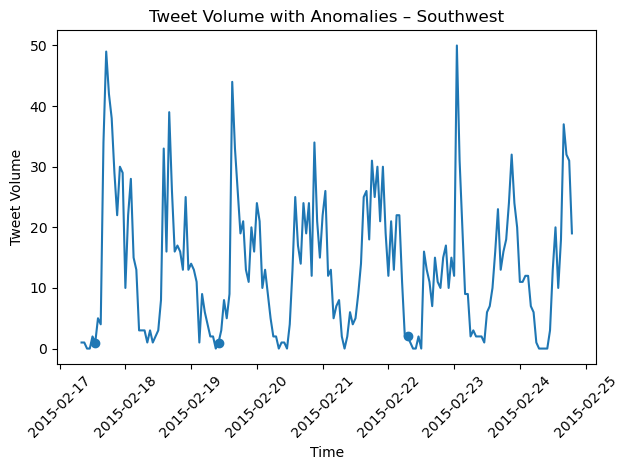

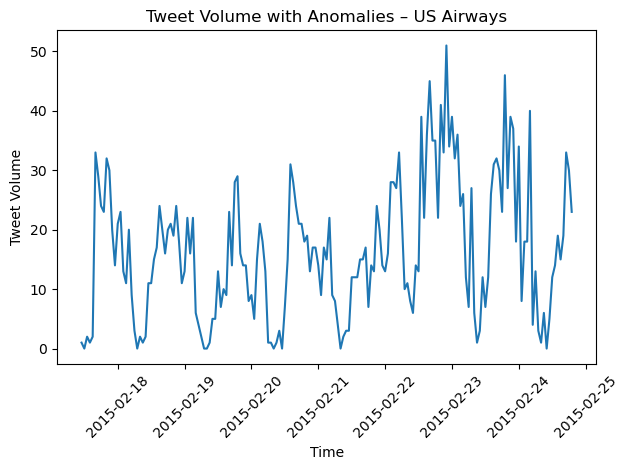

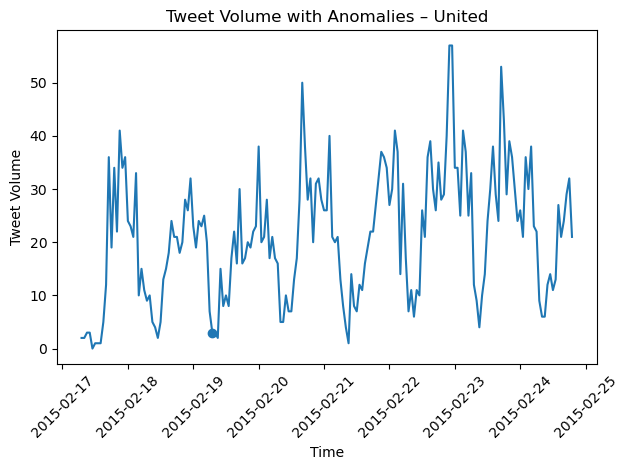

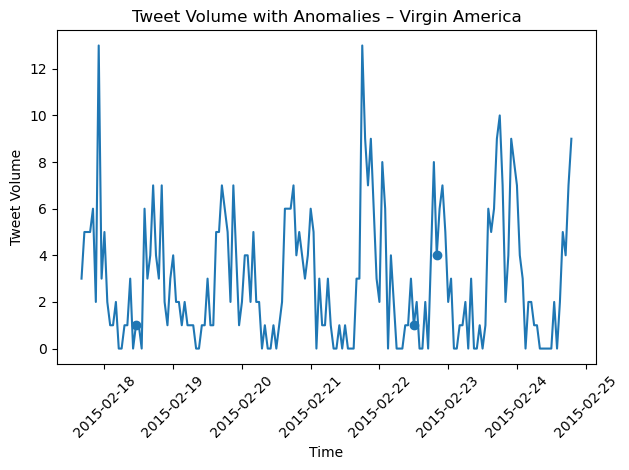

In [148]:
# Define a function to plot tweet volume and detected anomalies for a given airline
def plot_airline_anomalies(df, airline_name):
    
    # Filter data for the selected airline and sort by time
    g = df[df["airline"] == airline_name].sort_values("hour_ts")

    # Create a new figure for the plot
    plt.figure()
    
    # Plot tweet volume over time
    plt.plot(g["hour_ts"], g["tweet_volume"])
    
    # Identify rows marked as anomalies by both models
    anoms = g[g["both_anomaly"] == 1]
    
    # Overlay anomaly points on the tweet volume plot
    plt.scatter(anoms["hour_ts"], anoms["tweet_volume"])

    # Add title and axis labels
    plt.title(f"Tweet Volume with Anomalies – {airline_name}")
    plt.xlabel("Time")
    plt.ylabel("Tweet Volume")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Generate anomaly plots for each airline
for airline in features_hourly["airline"].unique():
    plot_airline_anomalies(features_hourly, airline)


In [150]:
# Create a validated crisis signal using stricter anomaly conditions
features_hourly["validated_crisis_signal"] = (
    # Both models must detect an anomaly
    (features_hourly["both_anomaly"] == 1) &
    
    # Negative sentiment spike must be significant
    (features_hourly["neg_rate_z"] > 2) &
    
    # Tweet volume spike must be significant
    (features_hourly["tweet_volume_z"] > 2)
).astype(int)

# Print the total number of validated crisis signals
print("Validated crisis signals:", features_hourly["validated_crisis_signal"].sum())


Validated crisis signals: 1


In [152]:
# Filter rows where a validated crisis signal is detected
validated = (
    features_hourly[features_hourly["validated_crisis_signal"] == 1]
    
    # Select key columns for crisis analysis
    .loc[:, [
        "airline", "hour_ts", "tweet_volume", "neg_rate",
        "tweet_volume_z", "neg_rate_z"
    ]]
)

# Display the validated crisis events
validated


,airline,hour_ts,tweet_volume,neg_rate,tweet_volume_z,neg_rate_z
89,American,2015-02-22 21:00:00+00:00,109.0,0.788991,3.377997,3.018933


In [154]:
# Identify stronger escalation signals using higher z-score thresholds
features_hourly["crisis_escalation"] = (
    (features_hourly["neg_rate_z"] > 3) &
    (features_hourly["tweet_volume_z"] > 3)
).astype(int)

# Estimate the time gap between first validated crisis signal and escalation
timing = (
    features_hourly
    .groupby("airline")
    
    # For each airline, compute index difference between escalation and validation
    .apply(
        lambda g: (
            g["crisis_escalation"].idxmax() - g["validated_crisis_signal"].idxmax()
        )
        if g["validated_crisis_signal"].any() and g["crisis_escalation"].any()
        else np.nan
    )
)

# Display estimated escalation timing for each airline
timing


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/690152840.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


airline
American         -52.0
Delta              NaN
Southwest          NaN
US Airways         NaN
United             NaN
Virgin America     NaN
dtype: float64

In [156]:
# Import StandardScaler for feature normalization
from sklearn.preprocessing import StandardScaler

# Define the list of candidate feature columns
candidate_features = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]

# Keep only the feature columns that are present in the dataset
feature_cols = [c for c in candidate_features if c in features_hourly.columns]

# Display the final list of features used for modeling
print("Using features:", feature_cols)

# Create the feature matrix and handle missing or infinite values
X = (
    features_hourly[feature_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

# Initialize the standard scaler
scaler = StandardScaler()

# Scale the feature matrix
X_scaled = scaler.fit_transform(X)

# Display the shape of the feature matrix
X.shape


Using features: ['tweet_volume', 'neg_rate', 'avg_retweets', 'hashtag_rate', 'mention_rate', 'tweet_volume_z', 'neg_rate_z', 'avg_retweets_z', 'hashtag_rate_z', 'neg_rate_diff']


(1027, 10)

In [158]:
# Define the file path for the anomaly results dataset
FEATURE_PATH = "/Users/pavankumar/Downloads/Dataset/anomaly_results_hourly.csv"

# Load the anomaly results CSV file into a DataFrame
features_hourly = pd.read_csv(FEATURE_PATH)

# Convert the hour_ts column to datetime format
features_hourly["hour_ts"] = pd.to_datetime(
    features_hourly["hour_ts"], utc=True, errors="coerce"
)

# Remove rows with invalid or missing timestamps
features_hourly = features_hourly.dropna(subset=["hour_ts"]).copy()

# Print the shape of the loaded dataset
print("Loaded features_hourly:", features_hourly.shape)

# Display the first few rows of the dataset
features_hourly.head()


Loaded features_hourly: (1027, 27)


,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate,tweet_volume_roll_mean,...,avg_retweets_z,hashtag_rate_roll_mean,hashtag_rate_roll_std,hashtag_rate_z,neg_rate_diff,if_score,if_anomaly,oc_score,oc_anomaly,both_anomaly
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.175835,0,0.165629,0,0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,-1.0,0.095120,0,0.000223,0,0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.170998,0,-0.000487,1,0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.170998,0,-0.000487,1,0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.170998,0,-0.000487,1,0


In [166]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Define the list of candidate feature columns
candidate_features = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]

# Keep only the features that exist in the dataset
feature_cols = [c for c in candidate_features if c in features_hourly.columns]

# Display the features used for importance analysis
print("Using features:", feature_cols)

# Create the feature matrix and handle missing or infinite values
X = features_hourly[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# Initialize and apply standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the Isolation Forest model
iso = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)

# Fit the model on the scaled feature matrix
iso.fit(X_scaled)

# Custom scoring function for IsolationForest (higher = more "normal")
def iso_scorer(estimator, X, y=None):
    return estimator.decision_function(X).mean()

# Compute permutation importance using the custom scorer
r = permutation_importance(
    iso,
    X_scaled,
    y=None,
    scoring=iso_scorer,
    n_repeats=15,
    random_state=42,
    n_jobs=-1
)

# Create a DataFrame of feature importances
importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)

# Normalize importance scores for easier comparison
total = importance["importance"].sum()
importance["importance_norm"] = importance["importance"] / total if total != 0 else 0.0

# Display feature importance results
importance


Using features: ['tweet_volume', 'neg_rate', 'avg_retweets', 'hashtag_rate', 'mention_rate', 'tweet_volume_z', 'neg_rate_z', 'avg_retweets_z', 'hashtag_rate_z', 'neg_rate_diff']


,feature,importance,importance_norm
1,neg_rate,0.007070,0.200202
0,tweet_volume,0.005590,0.158306
5,tweet_volume_z,0.004150,0.117525
6,neg_rate_z,0.003764,0.106579
3,hashtag_rate,0.002998,0.084884
7,avg_retweets_z,0.002868,0.081205
8,hashtag_rate_z,0.002811,0.079614
9,neg_rate_diff,0.002219,0.062836
4,mention_rate,0.001971,0.055802
2,avg_retweets,0.001873,0.053048


In [162]:
# Train a baseline Isolation Forest model using all features
iso_base = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
iso_base.fit(X_scaled)

# Get baseline anomaly scores
base_scores = iso_base.decision_function(X_scaled)

# Initialize a list to store drop-feature importance results
imp_list = []

# Iterate through each feature to evaluate its importance
for j, feat in enumerate(feature_cols):
    
    # Remove one feature from the feature set
    X_drop = X.drop(columns=[feat])
    
    # Scale the reduced feature matrix
    scaler_drop = StandardScaler()
    X_drop_scaled = scaler_drop.fit_transform(X_drop)

    # Train Isolation Forest on the reduced feature set
    iso_drop = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
    iso_drop.fit(X_drop_scaled)
    
    # Get anomaly scores after dropping the feature
    drop_scores = iso_drop.decision_function(X_drop_scaled)

    # Calculate the average change in scores caused by dropping the feature
    impact = np.mean(np.abs(base_scores - drop_scores))
    
    # Store feature name and its impact score
    imp_list.append((feat, impact))

# Create a DataFrame of drop-feature importance scores
drop_importance = (
    pd.DataFrame(imp_list, columns=["feature", "drop_score_impact"])
      .sort_values("drop_score_impact", ascending=False)
)

# Normalize impact scores for easier comparison
drop_importance["impact_norm"] = (
    drop_importance["drop_score_impact"] / drop_importance["drop_score_impact"].sum()
)

# Display drop-feature importance results
drop_importance


,feature,drop_score_impact,impact_norm
9,neg_rate_diff,0.022690,0.166790
4,mention_rate,0.022158,0.162878
1,neg_rate,0.018908,0.138994
6,neg_rate_z,0.013889,0.102094
3,hashtag_rate,0.011393,0.083750
7,avg_retweets_z,0.010243,0.075292
5,tweet_volume_z,0.009772,0.071829
8,hashtag_rate_z,0.009609,0.070635
0,tweet_volume,0.008862,0.065144
2,avg_retweets,0.008515,0.062593


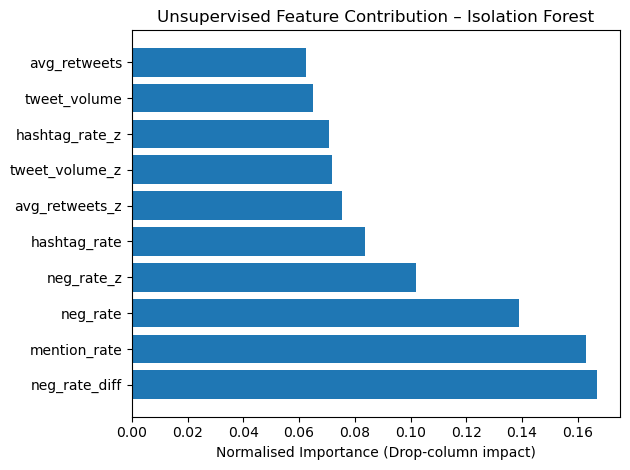

In [164]:
# Create a new figure for the feature importance plot
plt.figure()

# Plot normalized drop-column importance as a horizontal bar chart
plt.barh(drop_importance["feature"], drop_importance["impact_norm"])

# Label the x-axis
plt.xlabel("Normalised Importance (Drop-column impact)")

# Add a title to the plot
plt.title("Unsupervised Feature Contribution – Isolation Forest")

# Adjust layout to avoid label overlap
plt.tight_layout()

# Display the plot
plt.show()


In [170]:
# Initialize the Isolation Forest model with chosen parameters
iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)

# Train the Isolation Forest model on the scaled feature matrix
iso.fit(X_scaled)


IsolationForest(contamination=0.02, n_estimators=300, random_state=42)

In [172]:
# Get the path to the user's home directory
HOME = os.path.expanduser("~")

# Define the project directory path
PROJECT_DIR = os.path.join(HOME, "airline_anomaly_project")

# Create the project directory if it does not already exist
os.makedirs(PROJECT_DIR, exist_ok=True)

# Define the output path for the cleaned tweets file
OUT_PATH = os.path.join(PROJECT_DIR, "tweets_cleaned.csv")

# Save the cleaned tweets DataFrame to the project directory
df.to_csv(OUT_PATH, index=False)

# Confirm that the file has been saved
print("Saved to:", OUT_PATH)


Saved to: /Users/pavankumar/airline_anomaly_project/tweets_cleaned.csv


In [174]:
# Import pandas for data loading and manipulation
import pandas as pd

# Define the file path for the cleaned tweets dataset
CLEANED_PATH = "/Users/pavankumar/Downloads/Dataset/tweets_cleaned.csv"

# Load the cleaned tweets CSV file into a DataFrame
df = pd.read_csv(CLEANED_PATH)

# Print the shape of the dataset (rows, columns)
print(df.shape)

# Display the first few rows of the dataset
df.head()


(14640, 23)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negative_reason,negative_reason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,tweet_location,tweet_timezone,hour,dayofweek,date,tweet_text_clean,hashtags,mentions,hashtag_count,mention_count
0,568265091226800130,negative,0.9240,Late Flight,0.4904,American,negative,beaubertke,Late Flight,0,...,Texas,Central Time (US & Canada),4,3,2015-02-19,okay i think 1565 has waited long enough for a...,[],['americanair'],0,1
1,568551906634797056,positive,0.6242,NaN,0.0000,American,positive,byunsamuel,NaN,0,...,"Sunnyside, NY",Eastern Time (US & Canada),23,3,2015-02-19,hopefully you ll see bad ones as opportunity t...,[],['americanair'],0,1
2,568824537338417154,negative,1.0000,Customer Service Issue,0.6727,American,negative,KaiserSnowse,Customer Service Issue,0,...,NaN,Central Time (US & Canada),17,4,2015-02-20,how long does it take to get credit to my aa a...,[],['americanair'],0,1
3,569047438880841728,negative,1.0000,Lost Luggage,0.5345,American,negative,ohmal,Customer Service Issue\nLost Luggage,0,...,NaN,London,8,5,2015-02-21,you need to work harder on the disconnect betw...,[],['americanair'],0,1
4,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,...,"dallas, TX",NaN,19,6,2015-02-22,we have 8 ppl so we need 2 know how many seats...,[],['americanair'],0,1


In [176]:
# Get the path to the user's home directory
HOME = os.path.expanduser("~")

# Define the project directory path
PROJECT_DIR = os.path.join(HOME, "airline_anomaly_project")

# Create the project directory if it does not already exist
os.makedirs(PROJECT_DIR, exist_ok=True)

# Define the output file path for the cleaned tweets dataset
OUT_PATH = os.path.join(PROJECT_DIR, "tweets_cleaned.csv")

# Save the cleaned DataFrame to the project directory
df.to_csv(OUT_PATH, index=False)

# Confirm that the file has been saved
print("Saved to:", OUT_PATH)


Saved to: /Users/pavankumar/airline_anomaly_project/tweets_cleaned.csv


In [188]:
from sklearn.pipeline import Pipeline



In [178]:
# Define the list of feature columns used for modeling and analysis
feature_cols = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]



In [194]:
# Create a machine learning pipeline for anomaly detection
anomaly_pipeline = Pipeline(
    steps=[
        # Step 1: Standardize features to have zero mean and unit variance
        ("scaler", StandardScaler()),
        
        # Step 2: Detect anomalies using Isolation Forest
        ("isolation_forest", IsolationForest(
            n_estimators=300,
            contamination=0.02,
            random_state=42
        ))
    ]
)



In [196]:
# Create the feature matrix and replace missing values with 0
X = features_hourly[feature_cols].fillna(0)

# Fit the anomaly detection pipeline on the feature matrix
anomaly_pipeline.fit(X)


Pipeline(steps=[('scaler', StandardScaler()),
                ('isolation_forest',
                 IsolationForest(contamination=0.02, n_estimators=300,
                                 random_state=42))])

In [198]:
# Configure scikit-learn to display pipelines as diagrams
from sklearn import set_config
set_config(display="diagram")

# Display the anomaly detection pipeline structure
anomaly_pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('isolation_forest',
                 IsolationForest(contamination=0.02, n_estimators=300,
                                 random_state=42))])

In [200]:
# Import One-Class SVM for anomaly detection
from sklearn.svm import OneClassSVM

# Create a pipeline for Isolation Forest–based anomaly detection
if_pipeline = Pipeline(
    steps=[
        # Step 1: Standardize features
        ("scaler", StandardScaler()),
        
        # Step 2: Detect anomalies using Isolation Forest
        ("isolation_forest", IsolationForest(
            n_estimators=300,
            contamination=0.02,
            random_state=42
        ))
    ]
)

# Create a pipeline for One-Class SVM–based anomaly detection
oc_pipeline = Pipeline(
    steps=[
        # Step 1: Standardize features
        ("scaler", StandardScaler()),
        
        # Step 2: Detect anomalies using One-Class SVM
        ("ocsvm", OneClassSVM(
            kernel="rbf",
            nu=0.02,
            gamma="scale"
        ))
    ]
)


In [202]:
# Configure scikit-learn to display pipelines as diagrams
from sklearn import set_config
set_config(display="diagram")

# Display the Isolation Forest pipeline structure
if_pipeline



Pipeline(steps=[('scaler', StandardScaler()),
                ('isolation_forest',
                 IsolationForest(contamination=0.02, n_estimators=300,
                                 random_state=42))])

In [204]:
# Display the One-Class SVM pipeline structure
oc_pipeline


Pipeline(steps=[('scaler', StandardScaler()), ('ocsvm', OneClassSVM(nu=0.02))])

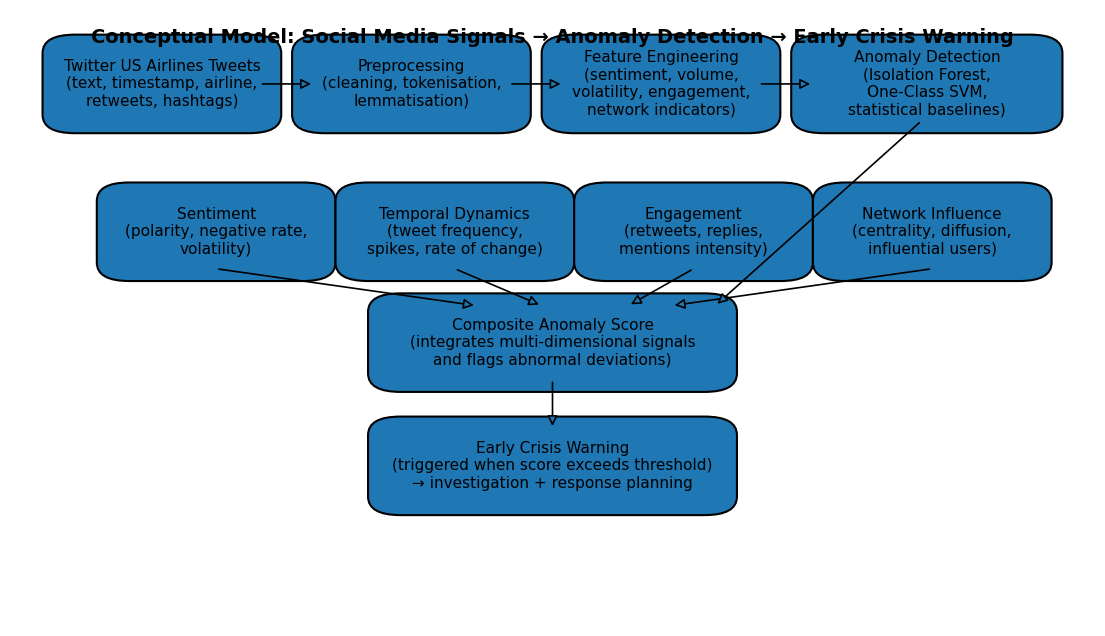

In [283]:
#Figure 4
# Conceptual Model Diagram (PNG) for your Dissertation
# Generates: conceptual_model_brand_crisis.png

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# Add a rounded rectangle with centered text
def add_box(ax, xy, w, h, text, fontsize=11):
    box = FancyBboxPatch(
        xy, w, h,
        boxstyle="round,pad=0.02,rounding_size=0.03",
        linewidth=1.5
    )
    ax.add_patch(box)
    ax.text(
        xy[0] + w / 2, xy[1] + h / 2, text,
        ha="center", va="center",
        fontsize=fontsize, wrap=True
    )

# Add a clean arrow between two points (x,y)
def add_arrow(ax, start, end):
    arrow = FancyArrowPatch(
        start, end,
        arrowstyle="-|>",
        mutation_scale=15,
        linewidth=1.2
    )
    ax.add_patch(arrow)

# Create canvas
fig = plt.figure(figsize=(14, 8))
ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

# Main pipeline (top row)
add_box(ax, (0.05, 0.82), 0.18, 0.12,
        "Twitter US Airlines Tweets\n(text, timestamp, airline,\nretweets, hashtags)")
add_box(ax, (0.28, 0.82), 0.18, 0.12,
        "Preprocessing\n(cleaning, tokenisation,\nlemmatisation)")
add_box(ax, (0.51, 0.82), 0.18, 0.12,
        "Feature Engineering\n(sentiment, volume,\nvolatility, engagement,\nnetwork indicators)")
add_box(ax, (0.74, 0.82), 0.21, 0.12,
        "Anomaly Detection\n(Isolation Forest,\nOne-Class SVM,\nstatistical baselines)")

# Arrows along the main pipeline
add_arrow(ax, (0.23, 0.88), (0.28, 0.88))
add_arrow(ax, (0.46, 0.88), (0.51, 0.88))
add_arrow(ax, (0.69, 0.88), (0.74, 0.88))

# Four constructs (middle row)
add_box(ax, (0.10, 0.58), 0.18, 0.12,
        "Sentiment\n(polarity, negative rate,\nvolatility)")
add_box(ax, (0.32, 0.58), 0.18, 0.12,
        "Temporal Dynamics\n(tweet frequency,\nspikes, rate of change)")
add_box(ax, (0.54, 0.58), 0.18, 0.12,
        "Engagement\n(retweets, replies,\nmentions intensity)")
add_box(ax, (0.76, 0.58), 0.18, 0.12,
        "Network Influence\n(centrality, diffusion,\ninfluential users)")

# Composite score (lower middle)
add_box(ax, (0.35, 0.40), 0.30, 0.12,
        "Composite Anomaly Score\n(integrates multi-dimensional signals\nand flags abnormal deviations)")

# Arrows from constructs to composite score
add_arrow(ax, (0.19, 0.58), (0.43, 0.52))
add_arrow(ax, (0.41, 0.58), (0.49, 0.52))
add_arrow(ax, (0.63, 0.58), (0.57, 0.52))
add_arrow(ax, (0.85, 0.58), (0.61, 0.52))

# Arrow from anomaly detection down to composite score
add_arrow(ax, (0.84, 0.82), (0.65, 0.52))

# Output (bottom row)
add_box(ax, (0.35, 0.20), 0.30, 0.12,
        "Early Crisis Warning\n(triggered when score exceeds threshold)\n→ investigation + response planning")

# Arrow from composite score to output
add_arrow(ax, (0.50, 0.40), (0.50, 0.32))

# Add diagram title
plt.text(
    0.5, 0.97,
    "Conceptual Model: Social Media Signals → Anomaly Detection → Early Crisis Warning",
    ha="center", va="top",
    fontsize=14, fontweight="bold"
)

# Save the figure as a PNG (high quality for dissertations)
plt.savefig("conceptual_model_brand_crisis.png", dpi=300, bbox_inches="tight")

# Show the diagram
plt.show()


In [210]:
# Define standard column names used throughout the pipeline
COLS = {
    "text": "text",
    "timestamp": "tweet_created",
    "sentiment": "airline_sentiment",
    "airline": "airline",
    "retweets": "retweet_count"
}

# Create a working copy of the raw dataset
df = df_raw.copy()

# Convert the timestamp column to datetime format (UTC) and coerce invalid values
df[COLS["timestamp"]] = pd.to_datetime(df[COLS["timestamp"]], errors="coerce", utc=True)

# Remove rows with missing timestamp or missing text
df = df.dropna(subset=[COLS["timestamp"], COLS["text"]])

# Sort tweets in chronological order
df = df.sort_values(COLS["timestamp"])

# Define regex patterns for URLs, hashtags, and mentions
URL_RE = re.compile(r"http\S+|www\.\S+")
HASHTAG_RE = re.compile(r"#\w+")
MENTION_RE = re.compile(r"@\w+")

# Define a function to clean tweet text (lowercase + remove URLs + remove punctuation)
def clean_text(text):
    text = str(text).lower()
    text = URL_RE.sub("", text)
    text = re.sub(r"[^\w\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

# Create a cleaned text column
df["text_clean"] = df[COLS["text"]].apply(clean_text)

# Count hashtags in each tweet
df["hashtag_count"] = df[COLS["text"]].apply(lambda x: len(HASHTAG_RE.findall(str(x))))

# Count mentions in each tweet
df["mention_count"] = df[COLS["text"]].apply(lambda x: len(MENTION_RE.findall(str(x))))

# Create a binary column for negative sentiment
df["is_negative"] = (df[COLS["sentiment"]] == "negative").astype(int)

# Convert timestamps into hourly windows for aggregation
df["time_window"] = df[COLS["timestamp"]].dt.floor("H")

# Aggregate tweet-level data into hourly airline-level features
hourly = (
    df
    .groupby(["time_window", COLS["airline"]])
    .agg(
        # Total tweet count per airline per hour
        tweet_volume=("text", "count"),
        
        # Proportion of negative tweets per airline per hour
        neg_rate=("is_negative", "mean"),
        
        # Average retweets per airline per hour
        avg_retweets=(COLS["retweets"], "mean"),
        
        # Average mention count per tweet in the hour
        mention_rate=("mention_count", "mean"),
        
        # Average hashtag count per tweet in the hour
        hashtag_rate=("hashtag_count", "mean")
    )
    .reset_index()
)

# Extract hour of day from the time window
hourly["hour"] = hourly["time_window"].dt.hour

# Extract weekday name from the time window
hourly["weekday"] = hourly["time_window"].dt.day_name()

# Sort hourly data before rolling calculations
hourly = hourly.sort_values(["airline", "time_window"])

# Compute rolling averages for volume and negative rate (3 hours and 12 hours)
for w in [3, 12]:
    
    # Rolling mean of tweet volume
    hourly[f"volume_roll_{w}h"] = (
        hourly.groupby("airline")["tweet_volume"]
        .transform(lambda x: x.rolling(w, min_periods=1).mean())
    )
    
    # Rolling mean of negative rate
    hourly[f"neg_rate_roll_{w}h"] = (
        hourly.groupby("airline")["neg_rate"]
        .transform(lambda x: x.rolling(w, min_periods=1).mean())
    )


# Measure how much tweet volume deviates from the 3-hour rolling baseline
hourly["volume_spike"] = hourly["tweet_volume"] - hourly["volume_roll_3h"]

# Measure hour-to-hour change in negative rate (per airline)
hourly["neg_rate_change"] = hourly.groupby("airline")["neg_rate"].diff().fillna(0)

# Print a preview of the engineered features
print("\nPreview of engineered features:")

# Display a small sample of key engineered features
display(
    hourly[
        [
            "time_window", "airline", "tweet_volume", "neg_rate",
            "avg_retweets", "mention_rate", "hashtag_rate",
            "volume_roll_3h", "neg_rate_roll_3h",
            "volume_spike", "neg_rate_change"
        ]
    ].head(10)
)



Preview of engineered features:


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/3588047771.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["time_window"] = df[COLS["timestamp"]].dt.floor("H")


,time_window,airline,tweet_volume,neg_rate,avg_retweets,mention_rate,hashtag_rate,volume_roll_3h,neg_rate_roll_3h,volume_spike,neg_rate_change
197,2015-02-19 04:00:00+00:00,American,1,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
285,2015-02-19 23:00:00+00:00,American,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.000000,-1.000000
368,2015-02-20 17:00:00+00:00,American,1,1.000000,0.000000,1.000000,0.000000,1.000000,0.666667,0.000000,1.000000
443,2015-02-21 08:00:00+00:00,American,1,1.000000,0.000000,1.000000,0.000000,1.000000,0.666667,0.000000,0.000000
601,2015-02-22 19:00:00+00:00,American,4,0.500000,0.000000,1.000000,0.250000,2.000000,0.833333,2.000000,-0.500000
607,2015-02-22 20:00:00+00:00,American,101,0.742574,0.039604,1.138614,0.148515,35.333333,0.747525,65.666667,0.242574
613,2015-02-22 21:00:00+00:00,American,109,0.788991,0.027523,1.119266,0.146789,71.333333,0.677188,37.666667,0.046417
619,2015-02-22 22:00:00+00:00,American,103,0.864078,0.058252,1.067961,0.203883,104.333333,0.798548,-1.333333,0.075087
625,2015-02-22 23:00:00+00:00,American,87,0.735632,0.045977,1.183908,0.229885,99.666667,0.796234,-12.666667,-0.128445
631,2015-02-23 00:00:00+00:00,American,106,0.839623,0.047170,1.066038,0.150943,98.666667,0.813111,7.333333,0.103990


In [218]:
# Figure 6
df_model = hourly.copy()

feature_cols = [c for c in [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "mention_rate",
    "hashtag_rate",
    "volume_spike",
    "neg_rate_change"
] if c in df_model.columns]

# Drop rows with missing feature values
df_model = df_model.dropna(subset=feature_cols).copy()

# Standardise features (important for OC-SVM; also helps IF consistency)
scaler = StandardScaler()
X = scaler.fit_transform(df_model[feature_cols].values)

# Isolation Forest
if_model = IsolationForest(
    n_estimators=300,
    contamination="auto",   # unsupervised default; can be tuned
    random_state=42
)
if_model.fit(X)

# One-Class SVM (RBF kernel for nonlinear boundaries)
svm_model = OneClassSVM(
    kernel="rbf",
    nu=0.05,      # expected fraction of anomalies (tune in sensitivity analysis)
    gamma="scale"
)
svm_model.fit(X)

# Predict returns: IF -> 1 normal, -1 anomaly ; OC-SVM -> 1 normal, -1 anomaly
df_model["if_anomaly"] = (if_model.predict(X) == -1).astype(int)
df_model["svm_anomaly"] = (svm_model.predict(X) == -1).astype(int)
df_model["both_anomaly"] = ((df_model["if_anomaly"] == 1) & (df_model["svm_anomaly"] == 1)).astype(int)

total_windows = len(df_model)
if_count = int(df_model["if_anomaly"].sum())
svm_count = int(df_model["svm_anomaly"].sum())
both_count = int(df_model["both_anomaly"].sum())

# By airline (optional but useful in results)
by_airline = (
    df_model.groupby("airline")[["if_anomaly", "svm_anomaly", "both_anomaly"]]
    .sum()
    .sort_values("both_anomaly", ascending=False)
)


print("MODEL OUTPUT — UNSUPERVISED ANOMALY DETECTION FOR EARLY CRISIS SIGNALS")



print("\nQuantitative anomaly summary (time windows analysed):")
print(f"- Total time windows: {total_windows:,}")
print(f"- Isolation Forest anomalies: {if_count:,} ({if_count/total_windows:.2%})")
print(f"- One-Class SVM anomalies:    {svm_count:,} ({svm_count/total_windows:.2%})")
print(f"- Agreement (both models):    {both_count:,} ({both_count/total_windows:.2%})")

print("\nAnomalies by airline (counts):")
print(by_airline.to_string())


cols_show = ["time_window", "airline"] + feature_cols + ["if_anomaly", "svm_anomaly", "both_anomaly"]

print("\nPreview: top anomaly windows where BOTH models agree (first 15 rows):")
agree_preview = df_model[df_model["both_anomaly"] == 1][cols_show].head(15)
print(agree_preview.to_string(index=False))

print("\nOutput ready: df_model contains anomaly flags for further validation and visualisation.")




MODEL OUTPUT — UNSUPERVISED ANOMALY DETECTION FOR EARLY CRISIS SIGNALS

Quantitative anomaly summary (time windows analysed):
- Total time windows: 874
- Isolation Forest anomalies: 75 (8.58%)
- One-Class SVM anomalies:    56 (6.41%)
- Agreement (both models):    41 (4.69%)

Anomalies by airline (counts):
                if_anomaly  svm_anomaly  both_anomaly
airline                                              
Virgin America          27           18            15
Delta                   15           11            10
Southwest               14           11             8
American                11           10             6
US Airways               5            6             2
United                   3            0             0

Preview: top anomaly windows where BOTH models agree (first 15 rows):
              time_window  airline  tweet_volume  neg_rate  avg_retweets  mention_rate  hashtag_rate  volume_spike  neg_rate_change  if_anomaly  svm_anomaly  both_anomaly
2015-02-22 20:00:00

In [287]:
#Figure 7

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


RAW = {
    "timestamp": "tweet_created",
    "airline": "airline",
    "sentiment": "airline_sentiment",
    "text": "text",
    "retweets": "retweet_count"
}


df_raw2 = df_raw.copy()
df_raw2[RAW["timestamp"]] = pd.to_datetime(df_raw2[RAW["timestamp"]], errors="coerce", utc=True)
df_raw2 = df_raw2.dropna(subset=[RAW["timestamp"], RAW["text"], RAW["airline"], RAW["sentiment"]]).copy()

df_raw2["time_window"] = df_raw2[RAW["timestamp"]].dt.floor("H")

# Binary negative label
df_raw2["is_negative"] = (df_raw2[RAW["sentiment"]].astype(str).str.lower() == "negative").astype(int)

# Mention + hashtag counts (simple)
df_raw2["mention_count"] = df_raw2[RAW["text"]].astype(str).str.count(r"@\w+")
df_raw2["hashtag_count"] = df_raw2[RAW["text"]].astype(str).str.count(r"#\w+")

# Hourly aggregation per airline
hourly = (
    df_raw2
    .groupby(["time_window", RAW["airline"]], as_index=False)
    .agg(
        tweet_volume=(RAW["text"], "count"),
        neg_rate=("is_negative", "mean"),
        avg_retweets=(RAW["retweets"], "mean"),
        mention_rate=("mention_count", "mean"),
        hashtag_rate=("hashtag_count", "mean")
    )
    .sort_values([RAW["airline"], "time_window"])
    .reset_index(drop=True)
)

# Temporal features
hourly["hour"] = hourly["time_window"].dt.hour
hourly["weekday"] = hourly["time_window"].dt.dayofweek  # 0=Mon ... 6=Sun

# Rolling baselines (3h, 12h) per airline
for w in [3, 12]:
    hourly[f"volume_roll_{w}h"] = hourly.groupby(RAW["airline"])["tweet_volume"].transform(
        lambda x: x.rolling(w, min_periods=1).mean()
    )
    hourly[f"neg_rate_roll_{w}h"] = hourly.groupby(RAW["airline"])["neg_rate"].transform(
        lambda x: x.rolling(w, min_periods=1).mean()
    )
    hourly[f"neg_volatility_{w}h"] = hourly.groupby(RAW["airline"])["neg_rate"].transform(
        lambda x: x.rolling(w, min_periods=1).std().fillna(0)
    )

# Spike / change features
hourly["volume_spike"] = hourly["tweet_volume"] - hourly["volume_roll_3h"]
hourly["neg_rate_change"] = hourly.groupby(RAW["airline"])["neg_rate"].diff().fillna(0)


feature_cols = [
    "tweet_volume", "neg_rate", "avg_retweets", "mention_rate", "hashtag_rate",
    "volume_spike", "neg_rate_change", "neg_volatility_3h", "neg_volatility_12h",
    "hour", "weekday"
]
feature_cols = [c for c in feature_cols if c in hourly.columns]

df_model = hourly.dropna(subset=feature_cols).copy()

scaler = StandardScaler()
X = scaler.fit_transform(df_model[feature_cols].values)

# Isolation Forest
if_model = IsolationForest(
    n_estimators=300,
    contamination="auto",
    random_state=42
)
if_model.fit(X)

# One-Class SVM (RBF)
svm_model = OneClassSVM(
    kernel="rbf",
    nu=0.05,
    gamma="scale"
)
svm_model.fit(X)

# Flags
df_model["if_anomaly"] = (if_model.predict(X) == -1).astype(int)
df_model["svm_anomaly"] = (svm_model.predict(X) == -1).astype(int)
df_model["both_anomaly"] = ((df_model["if_anomaly"] == 1) & (df_model["svm_anomaly"] == 1)).astype(int)

# Continuous anomaly scores (for ROC–AUC)
df_model["if_anom_score"] = -if_model.decision_function(X)
df_model["svm_anom_score"] = -svm_model.decision_function(X)


# Proxy crisis-like windows: top 5% neg_rate OR top 5% tweet_volume (per airline)
Q = 0.95  # set 0.90 to make labels less strict (more positives)

thr = (
    df_model.groupby(RAW["airline"])
    .agg(vol_thr=("tweet_volume", lambda s: s.quantile(Q)),
         neg_thr=("neg_rate", lambda s: s.quantile(Q)))
    .reset_index()
)

df_eval = df_model.merge(thr, on=RAW["airline"], how="left")

df_eval["proxy_crisis"] = (
    (df_eval["tweet_volume"] >= df_eval["vol_thr"]) |
    (df_eval["neg_rate"] >= df_eval["neg_thr"])
).astype(int)

y_true = df_eval["proxy_crisis"].values

print("\n" + "="*78)
print("EVALUATION OUTPUT (NO CRISIS LABELS): PROXY-LABEL METRICS + TIMELINESS")
print("="*78)

print("\nProxy crisis definition (automatic ground truth):")
print(f"- A time window is labelled crisis-like if tweet_volume OR neg_rate is in the top {int((1-Q)*100)}% per airline.")
print("- This is a proxy for abnormal behaviour consistent with early crisis escalation conditions.")

def prf(name, y_pred):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name:18s} Precision={p:.3f}  Recall={r:.3f}  F1={f:.3f}")

print("\nPrecision / Recall / F1 (against proxy labels):")
prf("Isolation Forest", df_eval["if_anomaly"].values)
prf("One-Class SVM", df_eval["svm_anomaly"].values)
prf("Agreement (Both)", df_eval["both_anomaly"].values)


# ROC–AUC requires both classes present
if len(np.unique(y_true)) < 2:
    print("\n ROC–AUC cannot be computed because proxy labels contain only one class.")
    print("Try lowering Q to 0.90 or 0.85.")
else:
    auc_if = roc_auc_score(y_true, df_eval["if_anom_score"].values)
    auc_svm = roc_auc_score(y_true, df_eval["svm_anom_score"].values)

    print("\nROC–AUC (continuous anomaly scores vs proxy labels):")
    print(f"- Isolation Forest ROC–AUC: {auc_if:.3f}")
    print(f"- One-Class SVM ROC–AUC:    {auc_svm:.3f}")


# Timeliness: Does the model flag an anomaly BEFORE a major event window?
LEAD_HOURS = 6

events = df_eval[df_eval["proxy_crisis"] == 1][["time_window", RAW["airline"]]].copy()
events = events.drop_duplicates().sort_values([RAW["airline"], "time_window"])

def lead_time_for_event(airline, event_time, flag_col):
    start = event_time - pd.Timedelta(hours=LEAD_HOURS)
    window = df_eval[
        (df_eval[RAW["airline"]] == airline) &
        (df_eval["time_window"] >= start) &
        (df_eval["time_window"] < event_time)
    ]
    anoms = window[window[flag_col] == 1]["time_window"]
    if len(anoms) == 0:
        return np.nan
    first = anoms.min()
    return (event_time - first) / pd.Timedelta(hours=1)

lead_rows = []
for _, e in events.iterrows():
    airline = e[RAW["airline"]]
    t = e["time_window"]
    lead_rows.append({
        "airline": airline,
        "event_time": t,
        "lead_if_hours": lead_time_for_event(airline, t, "if_anomaly"),
        "lead_svm_hours": lead_time_for_event(airline, t, "svm_anomaly"),
        "lead_both_hours": lead_time_for_event(airline, t, "both_anomaly"),
    })

lead_df = pd.DataFrame(lead_rows)

print("\nTimeliness (lead time before proxy crisis windows):")
def summarise(col):
    valid = lead_df[col].dropna()
    coverage = valid.shape[0] / max(1, lead_df.shape[0])
    if valid.empty:
        return coverage, np.nan, np.nan
    return coverage, valid.mean(), valid.median()

for col, name in [
    ("lead_if_hours", "Isolation Forest"),
    ("lead_svm_hours", "One-Class SVM"),
    ("lead_both_hours", "Agreement (Both)")
]:
    cov, mean_lead, med_lead = summarise(col)
    print(f"- {name:18s} Coverage={cov:.2%}  Mean lead={mean_lead:.2f}h  Median lead={med_lead:.2f}h")


df_eval.to_csv("evaluation_with_proxy_labels.csv", index=False)
lead_df.to_csv("timeliness_proxy_lead_times.csv", index=False)

print("\nSaved outputs:")
print("- evaluation_with_proxy_labels.csv")
print("- timeliness_proxy_lead_times.csv")
print("="*78 + "\n")


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/354159712.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_raw2["time_window"] = df_raw2[RAW["timestamp"]].dt.floor("H")



EVALUATION OUTPUT (NO CRISIS LABELS): PROXY-LABEL METRICS + TIMELINESS

Proxy crisis definition (automatic ground truth):
- A time window is labelled crisis-like if tweet_volume OR neg_rate is in the top 5% per airline.
- This is a proxy for abnormal behaviour consistent with early crisis escalation conditions.

Precision / Recall / F1 (against proxy labels):
Isolation Forest   Precision=0.309  Recall=0.238  F1=0.269
One-Class SVM      Precision=0.339  Recall=0.159  F1=0.216
Agreement (Both)   Precision=0.312  Recall=0.119  F1=0.172

ROC–AUC (continuous anomaly scores vs proxy labels):
- Isolation Forest ROC–AUC: 0.758
- One-Class SVM ROC–AUC:    0.766

Timeliness (lead time before proxy crisis windows):
- Isolation Forest   Coverage=42.86%  Mean lead=4.02h  Median lead=5.00h
- One-Class SVM      Coverage=34.92%  Mean lead=3.73h  Median lead=4.00h
- Agreement (Both)   Coverage=29.37%  Mean lead=3.78h  Median lead=4.00h

Saved outputs:
- evaluation_with_proxy_labels.csv
- timeliness_pr

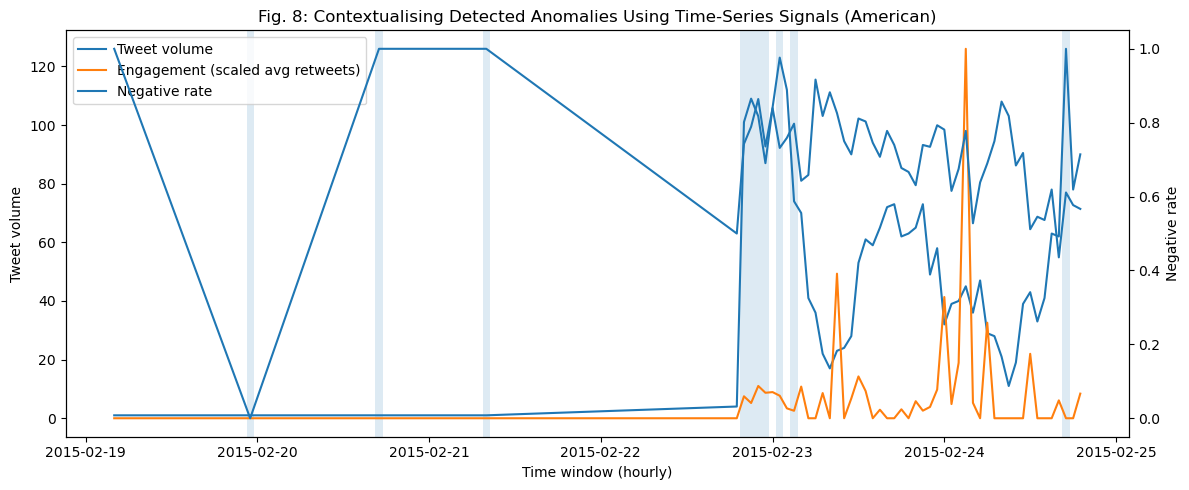

In [222]:
# Use evaluation DataFrame if available; otherwise fall back to modeling DataFrame
plot_df = df_eval.copy() if "df_eval" in globals() else df_model.copy()

# Ensure the time_window column is in datetime format
plot_df["time_window"] = pd.to_datetime(
    plot_df["time_window"], utc=True, errors="coerce"
)

# Remove rows with invalid timestamps and sort chronologically
plot_df = plot_df.dropna(subset=["time_window"]).sort_values("time_window")

# Select a single airline for clearer visual interpretation
# (recommended for dissertation figures)
AIRLINE = "American"  # change as needed
plot_df = plot_df[plot_df["airline"] == AIRLINE].copy()

# Select anomaly column (prefer agreement-based anomalies if available)
anom_col = "both_anomaly" if "both_anomaly" in plot_df.columns else "if_anomaly"

# Create the figure and primary axis
fig = plt.figure(figsize=(12, 5))
ax1 = plt.gca()

# Plot tweet volume over time (left y-axis)
ax1.plot(plot_df["time_window"], plot_df["tweet_volume"], label="Tweet volume")
ax1.set_xlabel("Time window (hourly)")
ax1.set_ylabel("Tweet volume")

# Create a secondary axis for negative sentiment rate
ax2 = ax1.twinx()

# Plot negative sentiment rate over time (right y-axis)
ax2.plot(plot_df["time_window"], plot_df["neg_rate"], label="Negative rate")
ax2.set_ylabel("Negative rate")

# Overlay engagement signal (average retweets), scaled to match tweet volume range
if "avg_retweets" in plot_df.columns:
    
    # Replace missing engagement values with zero
    ret = plot_df["avg_retweets"].fillna(0)
    
    # Scale retweets to the tweet volume range for visual comparability
    if ret.max() > 0:
        ret_scaled = (ret / ret.max()) * plot_df["tweet_volume"].max()
        ax1.plot(
            plot_df["time_window"],
            ret_scaled,
            label="Engagement (scaled avg retweets)"
        )

# Highlight anomaly windows using shaded vertical regions
if anom_col in plot_df.columns:
    
    # Extract timestamps where anomalies are detected
    anoms = plot_df[plot_df[anom_col] == 1]["time_window"].tolist()
    
    # Shade a one-hour window around each anomaly
    for t in anoms:
        ax1.axvspan(
            t - pd.Timedelta(minutes=30),
            t + pd.Timedelta(minutes=30),
            alpha=0.15
        )

# Add a dissertation-style figure title
plt.title(
    f"Fig. 8: Contextualising Detected Anomalies Using Time-Series Signals ({AIRLINE})"
)

# Combine legends from both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Adjust layout to prevent label overlap
plt.tight_layout()

# Display the figure
plt.show()


In [224]:
# Import Counter to summarise keyword frequencies
from collections import Counter

# Use df_eval if available; otherwise fall back to df_model
anom_df = df_eval.copy() if "df_eval" in globals() else df_model.copy()

# Ensure time_window is datetime and remove invalid timestamps
anom_df["time_window"] = pd.to_datetime(anom_df["time_window"], utc=True, errors="coerce")
anom_df = anom_df.dropna(subset=["time_window"]).copy()

# Define raw dataset column mapping (update if your dataset uses different names)
RAW = {
    "timestamp": "tweet_created",
    "airline": "airline",
    "text": "text",
    "sentiment": "airline_sentiment",
    "user": "name"
}

# Create a working copy of raw tweets
tweets = df_raw.copy()

# Convert raw timestamps to datetime (UTC) and remove invalid rows
tweets[RAW["timestamp"]] = pd.to_datetime(tweets[RAW["timestamp"]], utc=True, errors="coerce")
tweets = tweets.dropna(subset=[RAW["timestamp"], RAW["airline"], RAW["text"]]).copy()

# Create an hourly time window for alignment with anomaly windows
tweets["time_window"] = tweets[RAW["timestamp"]].dt.floor("H")

# Create a binary negative sentiment flag from the raw sentiment label
tweets["is_negative"] = (
    tweets[RAW["sentiment"]].astype(str).str.lower() == "negative"
).astype(int)

# If the configured user column does not exist, fall back to a proxy identifier
if RAW["user"] not in tweets.columns:
    
    # Try common alternatives as a best-effort proxy for unique users
    for alt in ["tweet_id", "user_id", "tweet_coord", "text"]:
        if alt in tweets.columns:
            RAW["user"] = alt
            break

# Define service-related keywords used to proxy complaint-type content
service_keywords = [
    "delay", "delayed", "cancel", "cancelled", "cancellation",
    "baggage", "luggage", "lost", "bag",
    "customer service", "support", "agent", "phone", "call",
    "refund", "rebook", "boarding", "gate", "hold", "wait",
    "overbook", "seat", "crew", "rude"
]

# Compile a case-insensitive regex pattern for service keywords
service_re = re.compile("|".join([re.escape(k) for k in service_keywords]), re.IGNORECASE)

# Define a small stopword list for lightweight tokenisation
STOPWORDS = set("""
a an and are as at be but by for from has have i in is it its of on or that the to was were with you your we our
this those these they them he she his her their not can could should would will just than then there here
""".split())

# Define a simple tokeniser for keyword extraction (URLs removed, alphabetic tokens only)
def tokenize(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    toks = [t for t in text.split() if t not in STOPWORDS and len(t) > 2]
    return toks

# Define thresholds for each validation criterion
TH_COMPLAINT_SHARE = 0.30     # >=30% tweets mention service issues
TH_UNIQUE_NEG_USERS = 8       # >=8 distinct users with negative tweets
TH_VOL_SPIKE = 1.5            # current volume >= 1.5 * rolling mean
TH_NEG_SPIKE = 0.15           # neg_rate increase vs rolling mean >= 0.15
TH_COHERENCE_TOP_SHARE = 0.12 # top keyword accounts for >=12% of tokens

# Ensure 3-hour rolling baselines exist (compute if missing)
if "volume_roll_3h" not in anom_df.columns:
    
    # Sort before rolling calculations
    anom_df = anom_df.sort_values(["airline", "time_window"])
    
    # Rolling baseline for tweet volume
    anom_df["volume_roll_3h"] = anom_df.groupby("airline")["tweet_volume"].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )

# Ensure negative rate baseline exists (compute if missing)
if "neg_rate_roll_3h" not in anom_df.columns:
    
    # Rolling baseline for negative rate
    anom_df["neg_rate_roll_3h"] = anom_df.groupby("airline")["neg_rate"].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )

# Choose which anomaly flag to validate (prefer agreement-based anomalies)
FLAG_COL = "both_anomaly" if "both_anomaly" in anom_df.columns else "if_anomaly"

# Extract unique anomaly windows with baseline context for validation
anom_windows = anom_df[anom_df[FLAG_COL] == 1][
    ["time_window", "airline", "tweet_volume", "neg_rate", "volume_roll_3h", "neg_rate_roll_3h"]
]
anom_windows = anom_windows.drop_duplicates().sort_values(["airline", "time_window"])

# Initialise a list for per-window validation results
results = []

# Iterate through each detected anomaly window
for _, row in anom_windows.iterrows():
    
    # Get the anomaly window time and airline identifier
    t = row["time_window"]
    airline = row["airline"]

    # Filter raw tweets for the same airline and hourly window
    tw = tweets[(tweets["time_window"] == t) & (tweets[RAW["airline"]] == airline)].copy()
    if len(tw) == 0:
        continue

    # Criterion 1: complaint concentration (service keywords)
    tw["service_hit"] = tw[RAW["text"]].astype(str).apply(lambda s: 1 if service_re.search(s) else 0)
    complaint_share = tw["service_hit"].mean()

    # Criterion 2: sentiment consistency across users (distinct negative authors)
    neg_tw = tw[tw["is_negative"] == 1]
    unique_neg_users = neg_tw[RAW["user"]].nunique()

    # Criterion 3: abrupt change vs rolling baseline (volume spike OR neg spike)
    vol_ratio = (row["tweet_volume"] / row["volume_roll_3h"]) if row["volume_roll_3h"] > 0 else np.nan
    neg_jump = (row["neg_rate"] - row["neg_rate_roll_3h"])
    abrupt_change = int((vol_ratio >= TH_VOL_SPIKE) or (neg_jump >= TH_NEG_SPIKE))

    # Criterion 4: contextual coherence (dominant keyword concentration)
    tokens = []
    for txt in tw[RAW["text"]].astype(str).tolist():
        tokens.extend(tokenize(txt))

    # Handle edge case where no valid tokens are found
    if len(tokens) == 0:
        top_share = 0.0
        top_word = ""
    else:
        counts = Counter(tokens)
        top_word, top_count = counts.most_common(1)[0]
        top_share = top_count / len(tokens)

    # Convert criteria into binary indicators using the defined thresholds
    c1 = int(complaint_share >= TH_COMPLAINT_SHARE)
    c2 = int(unique_neg_users >= TH_UNIQUE_NEG_USERS)
    c4 = int(top_share >= TH_COHERENCE_TOP_SHARE)

    # Compute how many criteria are met in total
    criteria_met = c1 + c2 + abrupt_change + c4

    # Define a meaningful anomaly if at least 2 out of 4 criteria are met
    meaningful = int(criteria_met >= 2)

    # Store the validation outputs for this anomaly window
    results.append({
        "time_window": t,
        "airline": airline,
        "tweet_volume": row["tweet_volume"],
        "neg_rate": round(row["neg_rate"], 3),
        "complaint_share": round(complaint_share, 3),
        "unique_neg_users": int(unique_neg_users),
        "vol_ratio_vs_3h": round(vol_ratio, 2) if pd.notnull(vol_ratio) else np.nan,
        "neg_jump_vs_3h": round(neg_jump, 3),
        "top_keyword": top_word,
        "top_keyword_share": round(top_share, 3),
        "criteria_met": int(criteria_met),
        "meaningful_anomaly": meaningful
    })

# Create a validation results table and prioritise the strongest cases
val_df = pd.DataFrame(results).sort_values(
    ["meaningful_anomaly", "criteria_met"],
    ascending=False
)

# Print header for validation output
print("CRITERIA-BASED ANOMALY VALIDATION OUTPUT (AUTOMATED PROXY)")

# Print the validation rule definition
print(f"Validation rule: An anomaly window is treated as meaningful if ≥2 of 4 criteria are met.")

# Print operational definitions for each criterion
print("\nOperationalised criteria:")
print(f"1) Complaint concentration: complaint_share ≥ {TH_COMPLAINT_SHARE}")
print(f"2) Sentiment consistency: unique negative users ≥ {TH_UNIQUE_NEG_USERS}")
print(f"3) Abrupt change vs baseline: volume_ratio ≥ {TH_VOL_SPIKE} OR neg_jump ≥ {TH_NEG_SPIKE}")
print(f"4) Contextual coherence: top keyword share ≥ {TH_COHERENCE_TOP_SHARE}")

# Compute summary statistics for meaningful anomalies
total = len(val_df)
meaningful_n = int(val_df["meaningful_anomaly"].sum()) if total else 0

# Print summary counts and proportions
print(f"\nSummary:")
print(f"- Anomaly windows evaluated: {total}")
print(f"- Meaningful anomalies (≥2 criteria): {meaningful_n} ({(meaningful_n/total if total else 0):.2%})")
print(f"- Treated as false positives: {total - meaningful_n}")

# Print a preview of the strongest validated anomaly windows
print("\nTop validated anomaly windows (first 12):")
show_cols = [
    "time_window", "airline", "tweet_volume", "neg_rate",
    "complaint_share", "unique_neg_users", "vol_ratio_vs_3h", "neg_jump_vs_3h",
    "top_keyword", "top_keyword_share", "criteria_met", "meaningful_anomaly"
]
print(val_df[show_cols].head(12).to_string(index=False))

# Save validation outputs as a CSV file for reporting and appendices
val_df.to_csv("anomaly_validation_output.csv", index=False)

# Confirm file output
print("\nSaved: anomaly_validation_output.csv")
print("="*78 + "\n")


CRITERIA-BASED ANOMALY VALIDATION OUTPUT (AUTOMATED PROXY)
Validation rule: An anomaly window is treated as meaningful if ≥2 of 4 criteria are met.

Operationalised criteria:
1) Complaint concentration: complaint_share ≥ 0.3
2) Sentiment consistency: unique negative users ≥ 8
3) Abrupt change vs baseline: volume_ratio ≥ 1.5 OR neg_jump ≥ 0.15
4) Contextual coherence: top keyword share ≥ 0.12

Summary:
- Anomaly windows evaluated: 48
- Meaningful anomalies (≥2 criteria): 21 (43.75%)
- Treated as false positives: 27

Top validated anomaly windows (first 12):
              time_window        airline  tweet_volume  neg_rate  complaint_share  unique_neg_users  vol_ratio_vs_3h  neg_jump_vs_3h  top_keyword  top_keyword_share  criteria_met  meaningful_anomaly
2015-02-22 20:00:00+00:00       American           101     0.743            0.525                57             2.86          -0.005  americanair              0.091             3                   1
2015-02-22 21:00:00+00:00       America

/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/3421976732.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tweets["time_window"] = tweets[RAW["timestamp"]].dt.floor("H")


In [226]:
# Import preprocessing, anomaly detection models, and model inspection tools
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

# Define the dataset path and load the raw CSV file
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"
df_raw = pd.read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)

# Define a helper function to pick the first matching column name from candidates
def pick_first_existing(columns, candidates):
    for c in candidates:
        if c in columns:
            return c
    return None

# Store the raw column names
cols = df_raw.columns

# Detect key columns using common candidate names across dataset versions
time_col = pick_first_existing(cols, ["tweet_created_at", "created_at", "tweet_created", "created_at_utc"])
text_col = pick_first_existing(cols, ["text", "tweet_text", "airline_sentiment_text"])
airline_col = pick_first_existing(cols, ["airline", "airline_name"])
sentiment_col = pick_first_existing(cols, ["airline_sentiment", "sentiment"])
retweet_col = pick_first_existing(cols, ["retweet_count", "retweetCount", "retweets"])

# Detect an optional user column (not always available)
user_col = pick_first_existing(cols, ["name", "username", "user", "screen_name", "twitter_handle"])

# Print detected column mappings for transparency and debugging
print("Detected columns:")
print(" time_col     =", time_col)
print(" text_col     =", text_col)
print(" airline_col  =", airline_col)
print(" sentiment_col=", sentiment_col)
print(" retweet_col  =", retweet_col)
print(" user_col     =", user_col)

# Stop early if the required columns are not found
if time_col is None or airline_col is None or sentiment_col is None:
    raise ValueError("Missing required columns. Please check df_raw.columns and update candidates above.")

# Create a working copy of the dataset for preprocessing
df = df_raw.copy()

# Convert the detected time column to datetime and remove invalid timestamps
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])

# Rename key columns to standard names used downstream
df = df.rename(columns={time_col: "timestamp", airline_col: "airline", sentiment_col: "sentiment"})

# Create a retweet_count column (fill with 0 if not present)
if retweet_col is None:
    df["retweet_count"] = 0
else:
    df = df.rename(columns={retweet_col: "retweet_count"})
    df["retweet_count"] = pd.to_numeric(df["retweet_count"], errors="coerce").fillna(0)

# Create a text column (fill empty if not present)
if text_col is None:
    df["text"] = ""
else:
    df = df.rename(columns={text_col: "text"})
    df["text"] = df["text"].fillna("").astype(str)

# Create a user column if available, otherwise keep a placeholder column
if user_col is not None:
    df = df.rename(columns={user_col: "user"})
else:
    df["user"] = np.nan

# Create a binary negative sentiment indicator
df["is_negative"] = (df["sentiment"].astype(str).str.lower() == "negative").astype(int)

# Create simple content/behaviour flags from the tweet text
df["has_hashtag"] = df["text"].str.contains(r"#\w+", regex=True).astype(int)
df["has_mention"] = df["text"].str.contains(r"@\w+", regex=True).astype(int)
df["is_question"] = df["text"].str.contains(r"\?", regex=True).astype(int)

# Set timestamp as index and ensure chronological ordering
df = df.set_index("timestamp").sort_index()

# Aggregate tweets into hourly windows per airline to create time-series features
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean"),
          hashtag_rate=("has_hashtag", "mean"),
          mention_rate=("has_mention", "mean"),
          question_rate=("is_question", "mean"),
          unique_users=("user", lambda x: x.nunique() if x.notna().any() else np.nan)
      )
      .reset_index()
)

# Rename the time column for clarity
df_hourly = df_hourly.rename(columns={"timestamp": "time"})
print("Hourly shape:", df_hourly.shape)
print(df_hourly.head())

# Replace missing unique_users with 0 if user information is unavailable
if df_hourly["unique_users"].isna().all():
    df_hourly["unique_users"] = 0

# Add time-based predictors (hour of day and day of week)
df_hourly["hour_of_day"] = df_hourly["time"].dt.hour
df_hourly["day_of_week"] = df_hourly["time"].dt.dayofweek

# Define the final feature set for unsupervised models
FEATURES = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "question_rate",
    "unique_users",
    "hour_of_day",
    "day_of_week"
]

# Remove rows with missing feature values
model_df = df_hourly.dropna(subset=FEATURES).copy()

# Build the feature matrix and standardise it
X = model_df[FEATURES].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the expected anomaly fraction (tune during sensitivity analysis)
CONTAM = 0.05

# Train Isolation Forest and generate anomaly flags
if_model = IsolationForest(
    n_estimators=300,
    contamination=CONTAM,
    random_state=42
)
if_model.fit(X_scaled)
model_df["IF_anomaly"] = (if_model.predict(X_scaled) == -1).astype(int)

# Train One-Class SVM and generate anomaly flags
svm_model = OneClassSVM(kernel="rbf", nu=CONTAM, gamma="scale")
svm_model.fit(X_scaled)
model_df["SVM_anomaly"] = (svm_model.predict(X_scaled) == -1).astype(int)

# Train Local Outlier Factor and generate anomaly flags (fit_predict only)
lof_model = LocalOutlierFactor(n_neighbors=35, contamination=CONTAM)
model_df["LOF_anomaly"] = (lof_model.fit_predict(X_scaled) == -1).astype(int)

# Create a stronger anomaly signal where Isolation Forest and SVM both agree
model_df["both_IF_SVM"] = (
    (model_df["IF_anomaly"] == 1) &
    (model_df["SVM_anomaly"] == 1)
).astype(int)

# Summarise how many anomaly windows each model detects
summary_counts = pd.DataFrame({
    "Model": ["Isolation Forest", "One-Class SVM", "Local Outlier Factor", "IF & SVM agreement"],
    "Anomaly_windows": [
        int(model_df["IF_anomaly"].sum()),
        int(model_df["SVM_anomaly"].sum()),
        int(model_df["LOF_anomaly"].sum()),
        int(model_df["both_IF_SVM"].sum()),
    ],
    "Anomaly_rate": [
        float(model_df["IF_anomaly"].mean()),
        float(model_df["SVM_anomaly"].mean()),
        float(model_df["LOF_anomaly"].mean()),
        float(model_df["both_IF_SVM"].mean()),
    ]
})
print("\nModel Comparison (Anomaly Counts) ")
print(summary_counts.to_string(index=False))

# Summarise which airlines show the most anomalies (using Isolation Forest)
airline_anoms = (
    model_df.groupby("airline")["IF_anomaly"]
            .agg(total_windows="count", anomaly_windows="sum")
            .reset_index()
)
airline_anoms["anomaly_rate"] = airline_anoms["anomaly_windows"] / airline_anoms["total_windows"]
airline_anoms = airline_anoms.sort_values("anomaly_rate", ascending=False)

print("\nIsolation Forest: Anomalies by Airline")
print(airline_anoms.to_string(index=False))

# Use IF anomaly predictions as a proxy label for permutation importance
y_proxy = model_df["IF_anomaly"].values

# Compute permutation importance to estimate which features drive anomaly decisions
perm = permutation_importance(
    estimator=if_model,
    X=X_scaled,
    y=y_proxy,
    n_repeats=20,
    random_state=42
)

# Create a feature importance table
fi = pd.DataFrame({
    "feature": FEATURES,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

print("\nIsolation Forest: Feature Importance (Permutation Proxy) ")
print(fi.to_string(index=False))

# Define a helper function to plot time-series signals and anomaly markers for one airline
def plot_airline_timeline(airline_name, flag_col="IF_anomaly"):
    plot_df = model_df[model_df["airline"] == airline_name].sort_values("time").copy()
    if plot_df.empty:
        print("No data for airline:", airline_name)
        return

    fig = plt.figure(figsize=(12, 5))
    ax1 = plt.gca()

    # Plot tweet volume over time (left axis)
    ax1.plot(plot_df["time"], plot_df["tweet_volume"], label="Tweet volume")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Tweet volume")

    # Plot negative sentiment rate over time (right axis)
    ax2 = ax1.twinx()
    ax2.plot(plot_df["time"], plot_df["neg_rate"], label="Negative sentiment rate")
    ax2.set_ylabel("Negative sentiment rate")

    # Overlay anomaly points using tweet volume as the marker position
    anoms = plot_df[plot_df[flag_col] == 1]
    ax1.scatter(anoms["time"], anoms["tweet_volume"], marker="x", s=50, label=f"Anomalies ({flag_col})")

    # Add a descriptive title
    plt.title(f"Early Warning Signals — {airline_name} ({flag_col})")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.tight_layout()
    plt.show()

# Choose one airline to visualise
AIRLINE_TO_PLOT = "United"

# Plot anomalies detected by Isolation Forest
plot_airline_timeline(AIRLINE_TO_PLOT, "IF_anomaly")

# Plot agreement-based anomalies (Isolation Forest + One-Class SVM)
plot_airline_timeline(AIRLINE_TO_PLOT, "both_IF_SVM")

# Plot a horizontal bar chart of feature importance values
plt.figure(figsize=(10, 4))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Which features most strongly indicate anomalies? (Isolation Forest)")
plt.xlabel("Importance (higher = stronger signal)")
plt.tight_layout()
plt.show()

# Print a final completion message
print("\nDone Outputs generated: model comparison table, airline anomaly rates, feature importance, and visuals.")


Raw shape: (14640, 15)
Detected columns:
 time_col     = tweet_created
 text_col     = text
 airline_col  = airline
 sentiment_col= airline_sentiment
 retweet_col  = retweet_count
 user_col     = name
Hourly shape: (874, 9)
                       time    airline  tweet_volume  neg_rate  avg_retweets  \
0 2015-02-16 23:00:00-08:00      Delta             2       0.5           0.0   
1 2015-02-16 23:00:00-08:00     United             2       1.0           0.0   
2 2015-02-17 00:00:00-08:00  Southwest             1       1.0           0.0   
3 2015-02-17 00:00:00-08:00     United             2       1.0           0.0   
4 2015-02-17 01:00:00-08:00  Southwest             1       1.0           0.0   

   hashtag_rate  mention_rate  question_rate  unique_users  
0           0.5           1.0            0.0             2  
1           0.0           1.0            0.0             2  
2           0.0           1.0            0.0             1  
3           0.0           1.0            0.0       

/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/2756984376.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])



Model Comparison (Anomaly Counts) 
               Model  Anomaly_windows  Anomaly_rate
    Isolation Forest               44      0.050343
       One-Class SVM               47      0.053776
Local Outlier Factor               44      0.050343
  IF & SVM agreement               26      0.029748

Isolation Forest: Anomalies by Airline
       airline  total_windows  anomaly_windows  anomaly_rate
      American             53               11      0.207547
Virgin America            135               11      0.081481
     Southwest            167               10      0.059880
         Delta            170                8      0.047059
    US Airways            169                3      0.017751
        United            180                1      0.005556


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator IsolationForest(contamination=0.05, n_estimators=300, random_state=42) does not.


 Isolation Forest: Feature Importance (Permutation, AUC-based) 
      feature  importance
 avg_retweets    0.063888
 hashtag_rate    0.042890
question_rate    0.040653
 tweet_volume    0.024322
 unique_users    0.023964
  hour_of_day    0.003041
  day_of_week    0.002965
     neg_rate    0.002866
 mention_rate    0.000000


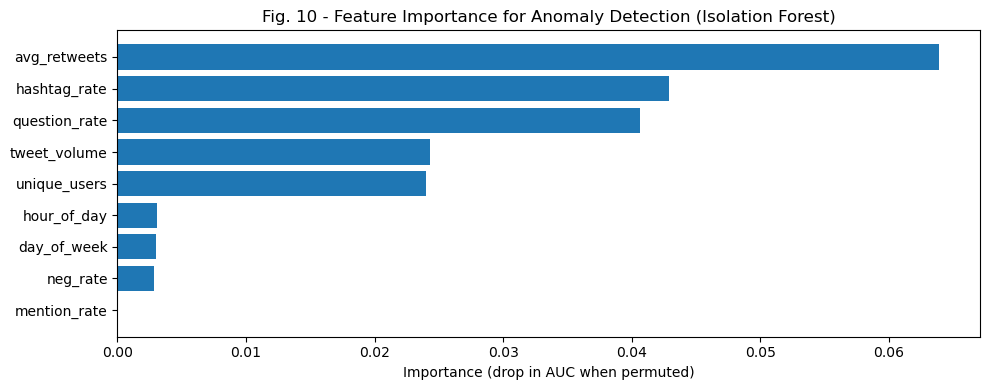

In [228]:
# Import permutation importance for feature contribution testing
from sklearn.inspection import permutation_importance

# Import AUC metric to evaluate separation between anomalies and normal points
from sklearn.metrics import roc_auc_score


# Create proxy labels using the Isolation Forest anomaly flags (1 = anomaly, 0 = normal)
y_proxy = model_df["IF_anomaly"].values

# Define a custom scorer that measures how well IF scores separate anomalies vs normal
def if_auc_scorer(estimator, X, y):
    """
    Compute AUC using Isolation Forest decision_function scores.

    decision_function returns higher scores for normal (inlier) points,
    so we invert the scores so higher values represent anomalies.
    """
    
    # Invert scores so anomalies are ranked higher
    scores = -estimator.decision_function(X)
    
    # Return a neutral score if only one class is present
    if len(np.unique(y)) < 2:
        return 0.5
    
    # Compute AUC between proxy labels and anomaly scores
    return roc_auc_score(y, scores)

# Compute permutation importance using the custom AUC-based scorer
perm = permutation_importance(
    estimator=if_model,
    X=X_scaled,
    y=y_proxy,
    scoring=if_auc_scorer,
    n_repeats=20,
    random_state=42
)

# Create a feature importance table sorted by strongest contribution
fi = pd.DataFrame({
    "feature": FEATURES,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

# Print the importance table for reporting
print("\n Isolation Forest: Feature Importance (Permutation, AUC-based) ")
print(fi.to_string(index=False))

# Create a figure for feature importance (horizontal bar chart)
plt.figure(figsize=(10, 4))

# Plot features in ascending order so the most important appears at the top
plt.barh(fi["feature"][::-1], fi["importance"][::-1])

# Add a dissertation-ready title and axis label
plt.title("Fig. 10 - Feature Importance for Anomaly Detection (Isolation Forest)")
plt.xlabel("Importance (drop in AUC when permuted)")

# Adjust layout for clean rendering
plt.tight_layout()

# Display the plot
plt.show()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/2278518082.py:60: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])



FEATURE SET: Sentiment-focused
- Isolation Forest sensitivity (contamination)
 contamination  anomaly_windows  anomaly_rate
          0.02                4      0.022222
          0.03                6      0.033333
          0.05                6      0.033333
          0.08               15      0.083333
          0.10               18      0.100000
Stable anomaly windows (>=60% settings): 6

- One-Class SVM sensitivity (nu)
  nu  anomaly_windows  anomaly_rate
0.02               26      0.144444
0.03               19      0.105556
0.05               37      0.205556
0.08               23      0.127778
0.10               24      0.133333
Stable anomaly windows (>=60% settings): 22

FEATURE SET: Volume-dominated
- Isolation Forest sensitivity (contamination)
 contamination  anomaly_windows  anomaly_rate
          0.02                4      0.022222
          0.03                5      0.027778
          0.05                9      0.050000
          0.08               13      0.072222


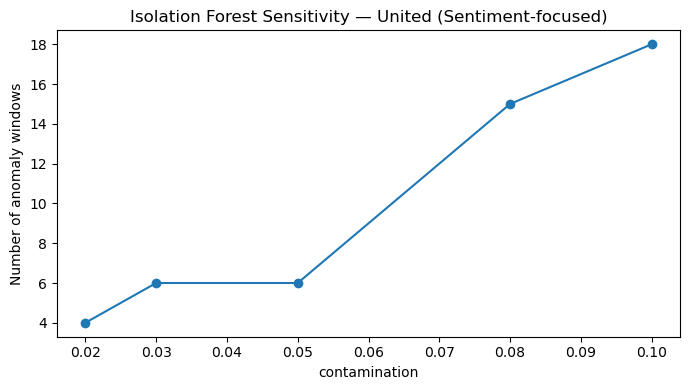

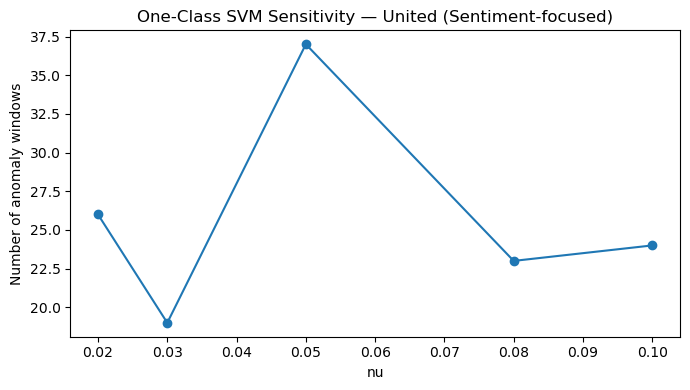

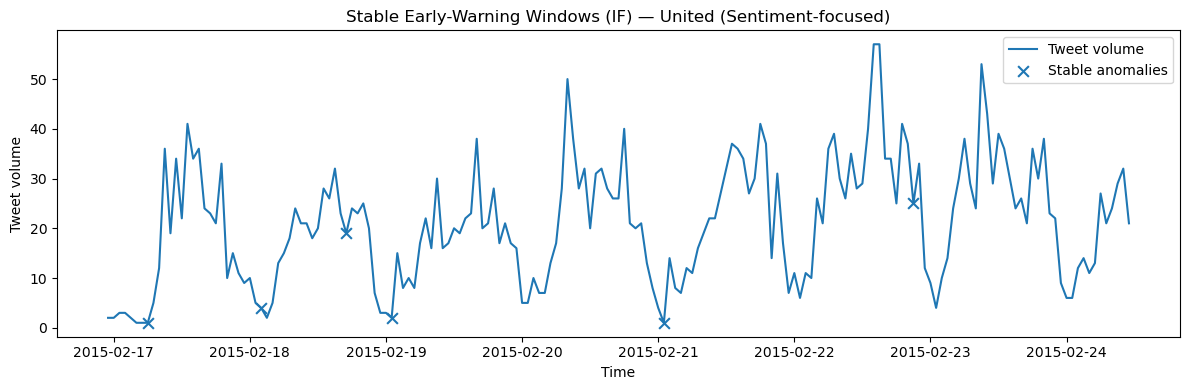

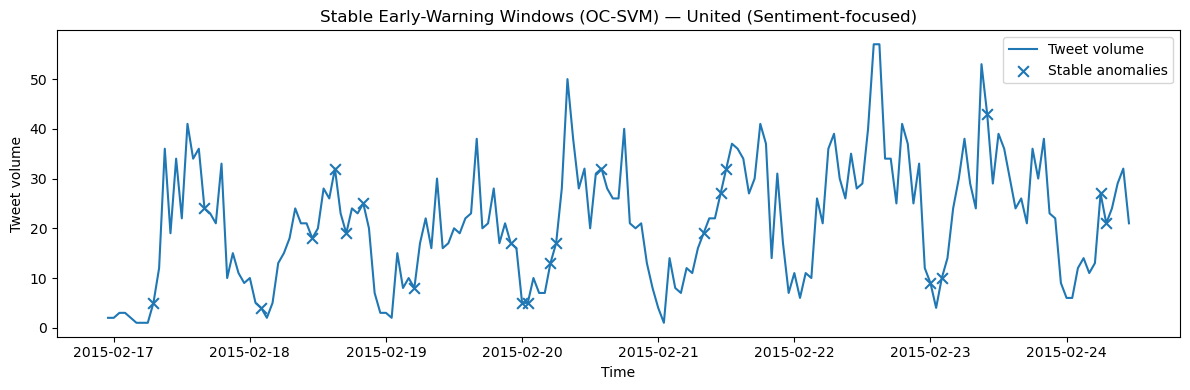

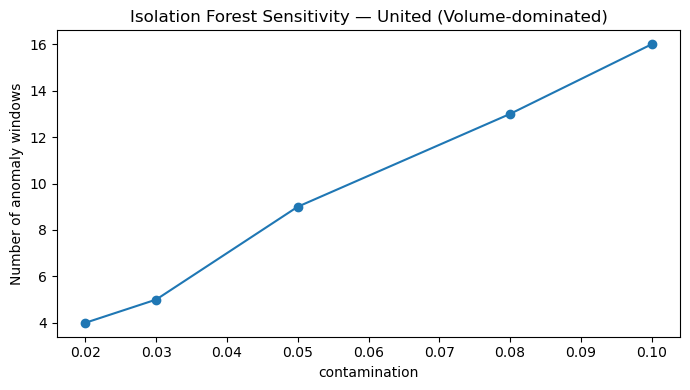

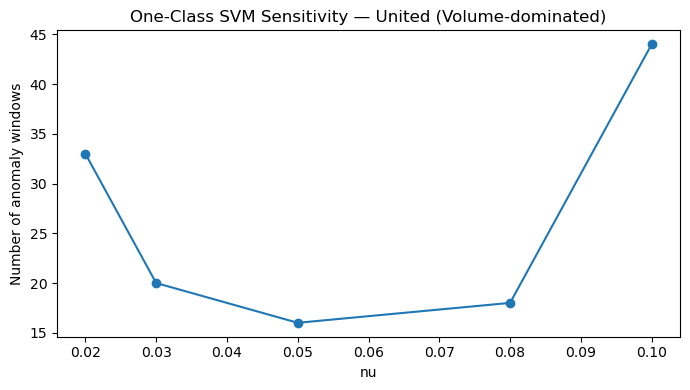

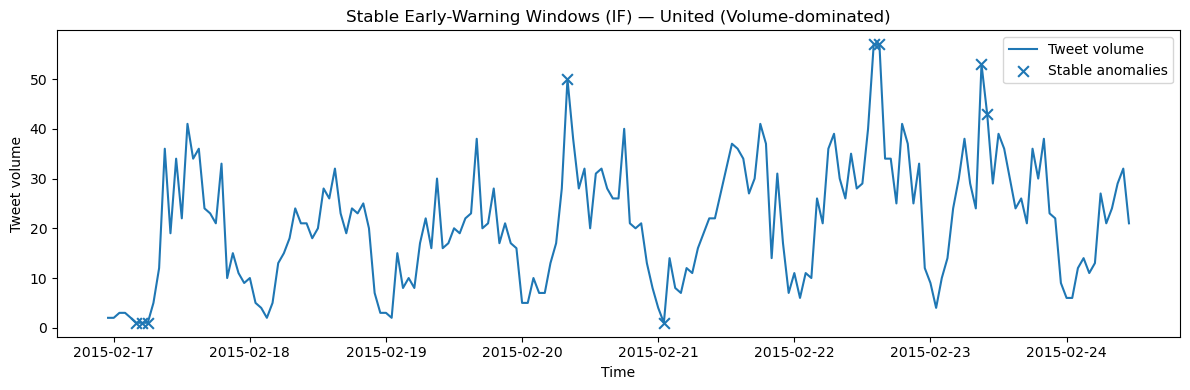

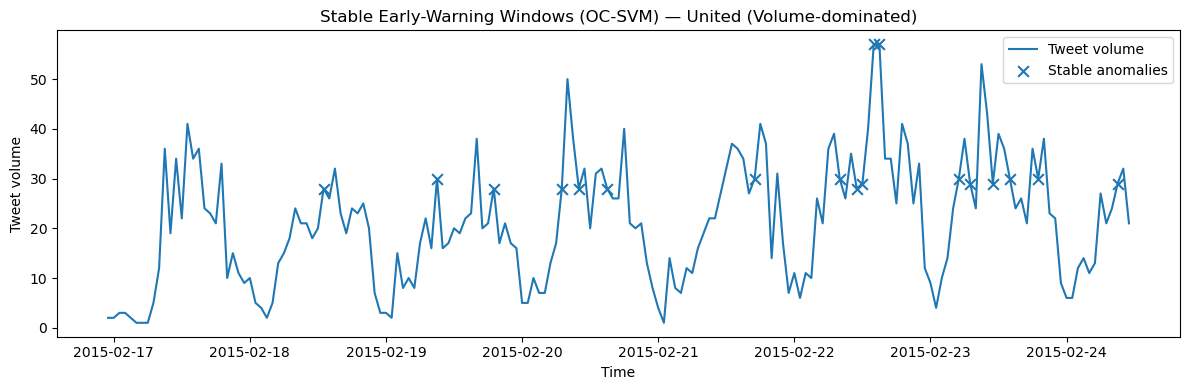

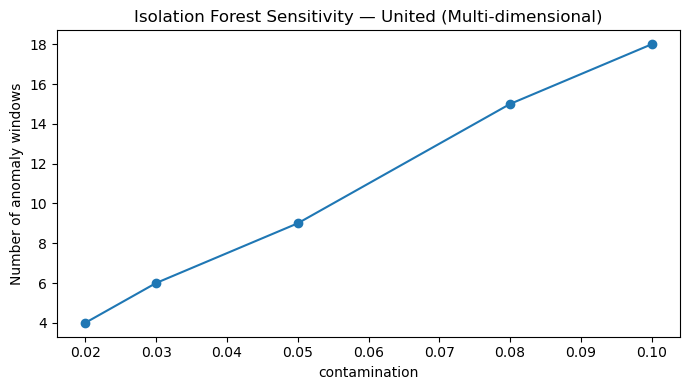

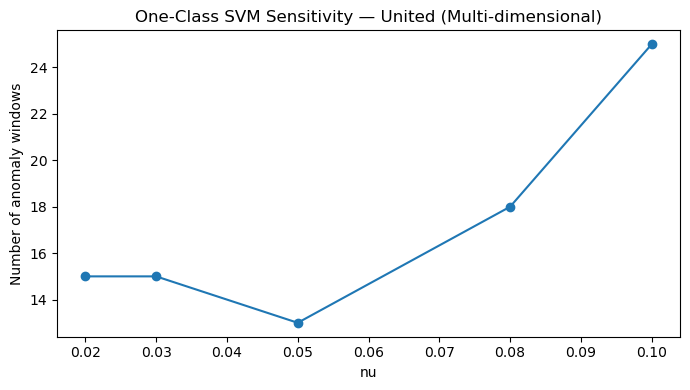

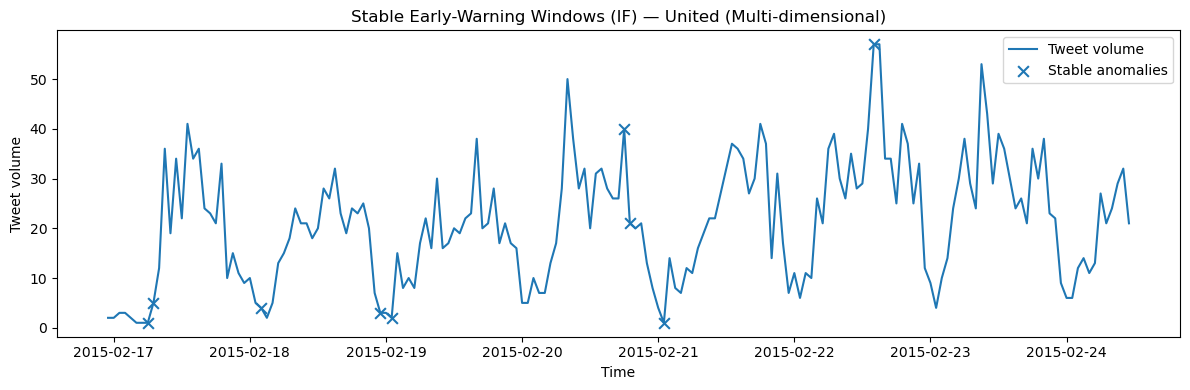

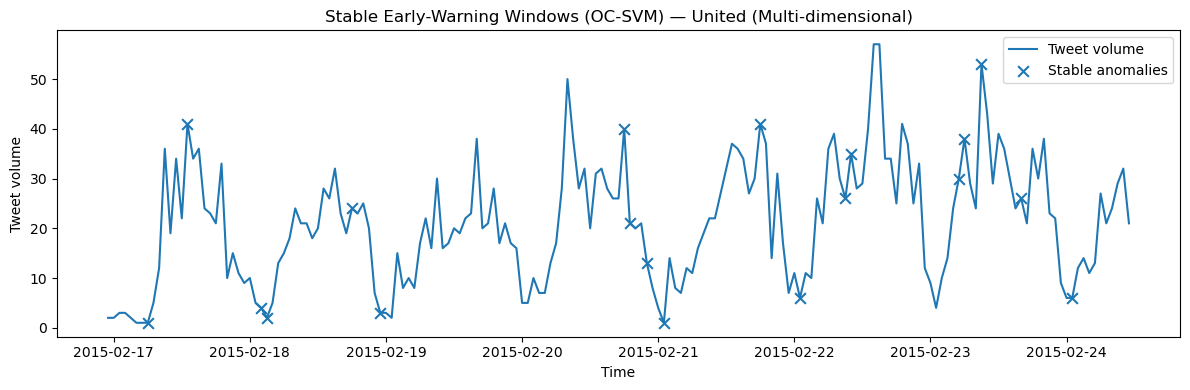


High-risk window proxy count: 3
This is useful for writing: 'anomalies aligned with reputational risk vs benign spikes'.


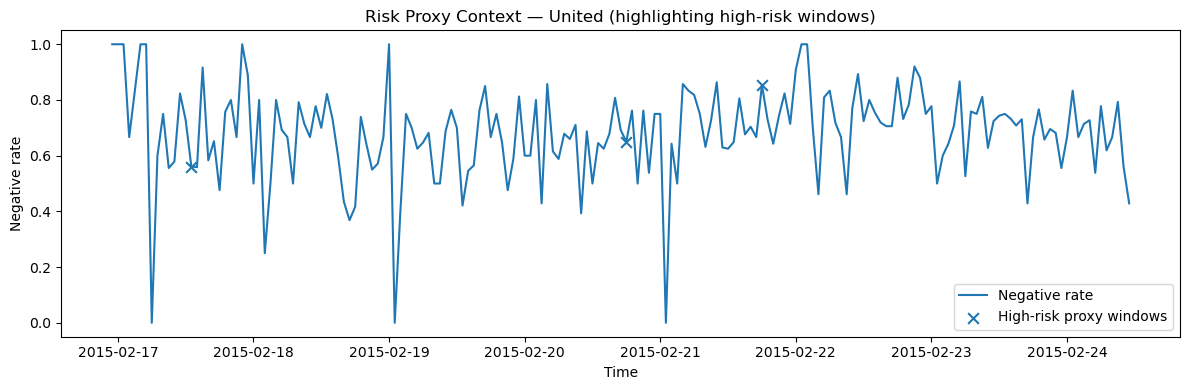


Done Sensitivity analysis + feature design impact outputs generated.


In [230]:
# Import scaling and unsupervised anomaly detection models
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Define the dataset path and load the raw CSV file
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"
df_raw = pd.read_csv(DATA_PATH)

# Define a helper function to detect the first matching column name
def pick_first_existing(columns, candidates):
    for c in candidates:
        if c in columns:
            return c
    return None

# Detect key columns across different dataset versions
time_col = pick_first_existing(df_raw.columns, ["tweet_created_at", "created_at", "tweet_created", "created_at_utc"])
text_col = pick_first_existing(df_raw.columns, ["text", "tweet_text", "airline_sentiment_text"])
airline_col = pick_first_existing(df_raw.columns, ["airline", "airline_name"])
sentiment_col = pick_first_existing(df_raw.columns, ["airline_sentiment", "sentiment"])
retweet_col = pick_first_existing(df_raw.columns, ["retweet_count", "retweetCount", "retweets"])

# Stop early if required columns are missing
if time_col is None or airline_col is None or sentiment_col is None:
    raise ValueError("Missing required columns. Print df_raw.columns and update candidates.")

# Create a working copy for preprocessing
df = df_raw.copy()

# Convert detected time column to datetime and remove invalid timestamps
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])

# Rename key columns to standard names for downstream analysis
df = df.rename(columns={time_col: "timestamp", airline_col: "airline", sentiment_col: "sentiment"})

# Create a standard retweet_count column (fill with 0 if unavailable)
df["retweet_count"] = pd.to_numeric(df[retweet_col], errors="coerce").fillna(0) if retweet_col else 0

# Create a standard text column (fill empty if unavailable)
if text_col:
    df = df.rename(columns={text_col: "text"})
    df["text"] = df["text"].fillna("").astype(str)
else:
    df["text"] = ""

# Create a binary negative sentiment indicator
df["is_negative"] = (df["sentiment"].astype(str).str.lower() == "negative").astype(int)

# Create simple text-based behaviour indicators
df["has_hashtag"] = df["text"].str.contains(r"#\w+", regex=True).astype(int)
df["has_mention"] = df["text"].str.contains(r"@\w+", regex=True).astype(int)

# Sort the dataset by timestamp for consistent temporal aggregation
df = df.set_index("timestamp").sort_index()

# Aggregate tweet-level data into hourly windows per airline
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean"),
          hashtag_rate=("has_hashtag", "mean"),
          mention_rate=("has_mention", "mean"),
      )
      .reset_index()
      .rename(columns={"timestamp": "time"})
)

# Add time-based contextual predictors
df_hourly["hour_of_day"] = df_hourly["time"].dt.hour
df_hourly["day_of_week"] = df_hourly["time"].dt.dayofweek

# Remove rows with missing values after feature construction
df_hourly = df_hourly.dropna()

# Define different feature sets to test design sensitivity
FEATURE_SETS = {
    "Sentiment-focused": ["neg_rate"],
    "Volume-dominated": ["tweet_volume"],
    "Multi-dimensional": ["tweet_volume", "neg_rate", "avg_retweets", "hashtag_rate", "mention_rate"]
}

# Define a function to run Isolation Forest across a contamination grid
def run_if_sensitivity(data, features, contamination_grid):
    X = data[features].values
    Xs = StandardScaler().fit_transform(X)

    results = []
    flags = {}

    for c in contamination_grid:
        model = IsolationForest(n_estimators=300, contamination=c, random_state=42)
        model.fit(Xs)
        anom = (model.predict(Xs) == -1).astype(int)

        results.append({
            "contamination": c,
            "anomaly_windows": int(anom.sum()),
            "anomaly_rate": float(anom.mean())
        })
        flags[c] = anom

    return pd.DataFrame(results), flags

# Define a function to run One-Class SVM across a nu grid
def run_svm_sensitivity(data, features, nu_grid):
    X = data[features].values
    Xs = StandardScaler().fit_transform(X)

    results = []
    flags = {}

    for nu in nu_grid:
        model = OneClassSVM(kernel="rbf", nu=nu, gamma="scale")
        model.fit(Xs)
        anom = (model.predict(Xs) == -1).astype(int)

        results.append({
            "nu": nu,
            "anomaly_windows": int(anom.sum()),
            "anomaly_rate": float(anom.mean())
        })
        flags[nu] = anom

    return pd.DataFrame(results), flags

# Define a function to select anomalies stable across a proportion of parameter settings
def stable_windows(data, flag_dict, setting_values, min_agreement=0.6):
    """
    Returns rows that are anomalies in at least min_agreement proportion of settings.
    """
    mat = np.column_stack([flag_dict[v] for v in setting_values])
    agreement = mat.mean(axis=1)
    out = data.copy()
    out["agreement_rate"] = agreement
    return out[out["agreement_rate"] >= min_agreement].copy()

# Select one airline for sensitivity analysis
AIRLINE = "United"
data_air = df_hourly[df_hourly["airline"] == AIRLINE].sort_values("time").reset_index(drop=True)

# Define parameter grids for Isolation Forest and One-Class SVM
IF_GRID = [0.02, 0.03, 0.05, 0.08, 0.10]
SVM_GRID = [0.02, 0.03, 0.05, 0.08, 0.10]

# Initialise a dictionary to store all outputs for each feature set
all_outputs = {}

# Run sensitivity analysis for each feature set
for set_name, feats in FEATURE_SETS.items():
    
    # Run Isolation Forest sensitivity testing
    if_tbl, if_flags = run_if_sensitivity(data_air, feats, IF_GRID)
    if_stable = stable_windows(data_air, if_flags, IF_GRID, min_agreement=0.6)

    # Run One-Class SVM sensitivity testing
    svm_tbl, svm_flags = run_svm_sensitivity(data_air, feats, SVM_GRID)
    svm_stable = stable_windows(data_air, svm_flags, SVM_GRID, min_agreement=0.6)

    all_outputs[set_name] = {
        "if_table": if_tbl,
        "if_stable": if_stable,
        "svm_table": svm_tbl,
        "svm_stable": svm_stable
    }

# Print sensitivity analysis summaries for each feature set
for set_name, outs in all_outputs.items():
    print("\n" + "="*60)
    print(f"FEATURE SET: {set_name}")
    print("- Isolation Forest sensitivity (contamination)")
    print(outs["if_table"].to_string(index=False))
    print(f"Stable anomaly windows (>=60% settings): {len(outs['if_stable'])}")

    print("\n- One-Class SVM sensitivity (nu)")
    print(outs["svm_table"].to_string(index=False))
    print(f"Stable anomaly windows (>=60% settings): {len(outs['svm_stable'])}")

# Define a plotting helper for parameter sensitivity curves
def plot_sensitivity(table, x_col, title):
    plt.figure(figsize=(7, 4))
    plt.plot(table[x_col], table["anomaly_windows"], marker="o")
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel("Number of anomaly windows")
    plt.tight_layout()
    plt.show()

# Define a plotting helper for stable anomaly windows on a timeline
def plot_stable_timeline(data, stable_df, title):
    plt.figure(figsize=(12, 4))
    plt.plot(data["time"], data["tweet_volume"], label="Tweet volume")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Tweet volume")

    if not stable_df.empty:
        plt.scatter(stable_df["time"], stable_df["tweet_volume"], marker="x", s=60, label="Stable anomalies")

    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot sensitivity curves and stable anomaly timelines for each feature set
for set_name, outs in all_outputs.items():
    plot_sensitivity(
        outs["if_table"], "contamination",
        f"Isolation Forest Sensitivity — {AIRLINE} ({set_name})"
    )

    plot_sensitivity(
        outs["svm_table"], "nu",
        f"One-Class SVM Sensitivity — {AIRLINE} ({set_name})"
    )

    plot_stable_timeline(
        data_air, outs["if_stable"],
        f"Stable Early-Warning Windows (IF) — {AIRLINE} ({set_name})"
    )

    plot_stable_timeline(
        data_air, outs["svm_stable"],
        f"Stable Early-Warning Windows (OC-SVM) — {AIRLINE} ({set_name})"
    )

# Create a simple risk proxy based on upper-tail thresholds for key indicators
risk_df = data_air.copy()
risk_df["risk_proxy"] = (
    (risk_df["neg_rate"] >= risk_df["neg_rate"].quantile(0.90)).astype(int) +
    (risk_df["tweet_volume"] >= risk_df["tweet_volume"].quantile(0.90)).astype(int) +
    (risk_df["avg_retweets"] >= risk_df["avg_retweets"].quantile(0.90)).astype(int)
)

# Label a window as high risk if at least 2 indicators are simultaneously high
risk_df["high_risk_window"] = (risk_df["risk_proxy"] >= 2).astype(int)

# Print a short summary of high-risk proxy windows
print("\n" + "="*60)
print("High-risk window proxy count:", int(risk_df["high_risk_window"].sum()))
print("This is useful for writing: 'anomalies aligned with reputational risk vs benign spikes'.")

# Plot negative rate and highlight high-risk proxy windows
plt.figure(figsize=(12, 4))
plt.plot(risk_df["time"], risk_df["neg_rate"], label="Negative rate")
plt.title(f"Risk Proxy Context — {AIRLINE} (highlighting high-risk windows)")
plt.xlabel("Time")
plt.ylabel("Negative rate")

hr = risk_df[risk_df["high_risk_window"] == 1]
plt.scatter(hr["time"], hr["neg_rate"], marker="x", s=60, label="High-risk proxy windows")

plt.legend()
plt.tight_layout()
plt.show()

# Print completion message
print("\nDone Sensitivity analysis + feature design impact outputs generated.")


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/2471847932.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])



=== Rolling Window Sensitivity (Isolation Forest) ===
 rolling_window_hours  anomaly_windows  anomaly_rate  data_points_used
                    3                9      0.050562               178
                    6                9      0.050847               177
                   12                9      0.051724               174
                   24                9      0.053571               168

Stable anomaly periods (>=50% of window configurations): 2


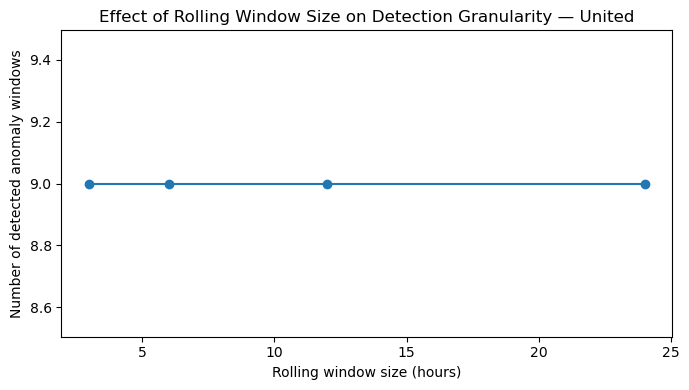

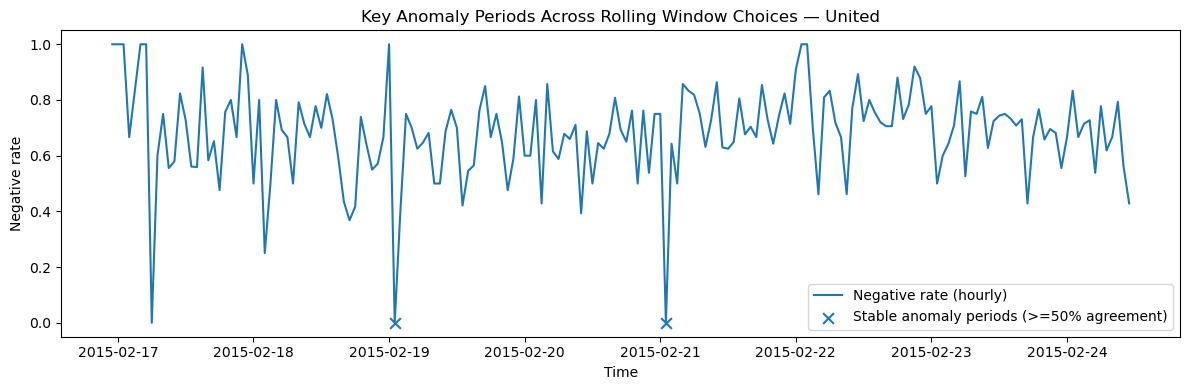

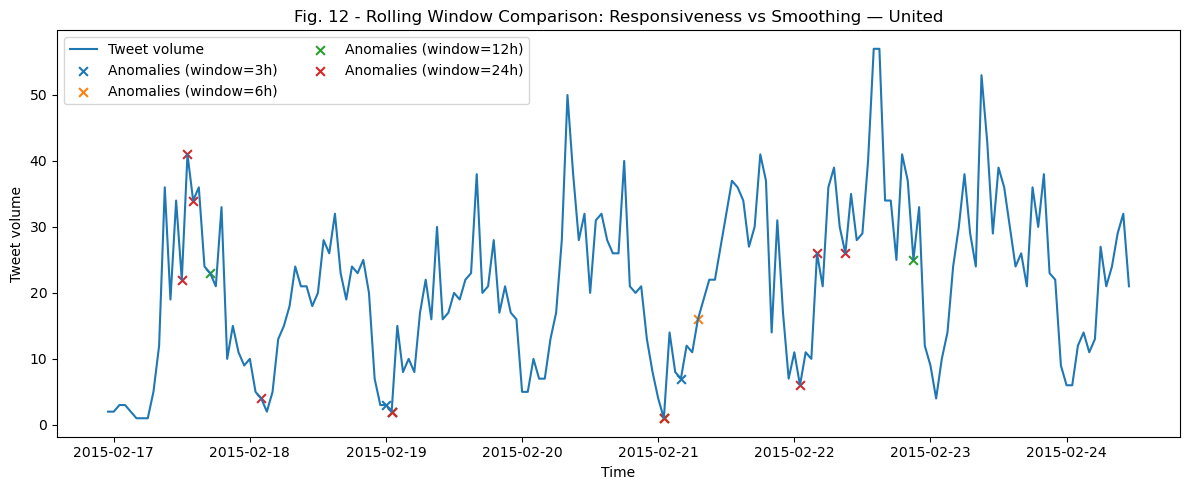

In [232]:
# Import scaling and Isolation Forest model for anomaly detection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Define a helper function to detect the first matching column name
def pick_first_existing(columns, candidates):
    for c in candidates:
        if c in columns:
            return c
    return None

# Detect core columns across common dataset variants
time_col = pick_first_existing(df_raw.columns, ["tweet_created_at", "created_at", "tweet_created", "created_at_utc"])
text_col = pick_first_existing(df_raw.columns, ["text", "tweet_text", "airline_sentiment_text"])
airline_col = pick_first_existing(df_raw.columns, ["airline", "airline_name"])
sentiment_col = pick_first_existing(df_raw.columns, ["airline_sentiment", "sentiment"])
retweet_col = pick_first_existing(df_raw.columns, ["retweet_count", "retweetCount", "retweets"])

# Stop early if required columns are missing
if time_col is None or airline_col is None or sentiment_col is None:
    raise ValueError("Missing required columns. Run df_raw.columns and update candidates.")

# Create a working copy of the raw data
df = df_raw.copy()

# Convert the detected time column to datetime and remove invalid timestamps
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])

# Rename key columns to standard names for downstream steps
df = df.rename(columns={time_col: "timestamp", airline_col: "airline", sentiment_col: "sentiment"})

# Create a standard retweet_count column (fill with 0 if retweets not available)
df["retweet_count"] = pd.to_numeric(df[retweet_col], errors="coerce").fillna(0) if retweet_col else 0

# Create a standard text column (fill empty if not available)
if text_col:
    df = df.rename(columns={text_col: "text"})
    df["text"] = df["text"].fillna("").astype(str)
else:
    df["text"] = ""

# Create a binary indicator for negative sentiment
df["is_negative"] = (df["sentiment"].astype(str).str.lower() == "negative").astype(int)

# Create a simple hashtag usage indicator from tweet text
df["has_hashtag"] = df["text"].str.contains(r"#\w+", regex=True).astype(int)

# Sort by timestamp and set it as index for hourly grouping
df = df.set_index("timestamp").sort_index()

# Aggregate tweet-level data into hourly windows per airline
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean"),
          hashtag_rate=("has_hashtag", "mean")
      )
      .reset_index()
      .rename(columns={"timestamp": "time"})
      .dropna()
)

# Choose one airline for rolling-window sensitivity testing
AIRLINE = "United"
data = df_hourly[df_hourly["airline"] == AIRLINE].sort_values("time").reset_index(drop=True)

# Define rolling window sizes (hours) to compare
WINDOWS = [3, 6, 12, 24]

# Define the expected anomaly fraction
CONTAM = 0.05

# Define a function to add rolling features for a chosen window size
def add_rolling_features(d, w):
    out = d.copy()
    out = out.sort_values("time")

    # Compute rolling means to represent smoothed baseline behaviour
    out[f"vol_roll_{w}h"] = out["tweet_volume"].rolling(w, min_periods=max(2, w//2)).mean()
    out[f"neg_roll_{w}h"] = out["neg_rate"].rolling(w, min_periods=max(2, w//2)).mean()
    out[f"rt_roll_{w}h"]  = out["avg_retweets"].rolling(w, min_periods=max(2, w//2)).mean()
    out[f"hash_roll_{w}h"]= out["hashtag_rate"].rolling(w, min_periods=max(2, w//2)).mean()

    # Compute a rolling change feature to capture shifts in negative sentiment
    out[f"neg_diff_{w}h"] = out[f"neg_roll_{w}h"].diff()

    return out

# Define a function to run Isolation Forest using selected features
def run_if(d, feature_cols):
    tmp = d.dropna(subset=feature_cols).copy()
    X = tmp[feature_cols].values
    Xs = StandardScaler().fit_transform(X)

    model = IsolationForest(n_estimators=300, contamination=CONTAM, random_state=42)
    model.fit(Xs)
    tmp["IF_anomaly"] = (model.predict(Xs) == -1).astype(int)
    return tmp

# Create containers for sensitivity results and anomaly flags per window
results = []
flags_by_window = {}

# Run detection for each rolling window size
for w in WINDOWS:
    d_w = add_rolling_features(data, w)

    # Define rolling feature names for this window configuration
    feats = [
        f"vol_roll_{w}h",
        f"neg_roll_{w}h",
        f"rt_roll_{w}h",
        f"hash_roll_{w}h",
        f"neg_diff_{w}h"
    ]

    # Train and predict anomalies using Isolation Forest
    out_w = run_if(d_w, feats)

    # Store anomaly flags indexed by time for stability comparison
    flags_by_window[w] = out_w.set_index("time")["IF_anomaly"]

    # Store summary statistics for this window size
    results.append({
        "rolling_window_hours": w,
        "anomaly_windows": int(out_w["IF_anomaly"].sum()),
        "anomaly_rate": float(out_w["IF_anomaly"].mean()),
        "data_points_used": int(len(out_w))
    })

# Build and print the rolling-window sensitivity table
sens_table = pd.DataFrame(results).sort_values("rolling_window_hours")
print("\n=== Rolling Window Sensitivity (Isolation Forest) ===")
print(sens_table.to_string(index=False))

# Compute a common set of timestamps shared across all window configurations
common_times = None
for w in WINDOWS:
    idx = flags_by_window[w].index
    common_times = idx if common_times is None else common_times.intersection(idx)

# Build a matrix of anomaly flags across window sizes (aligned by time)
mat = np.column_stack([flags_by_window[w].loc[common_times].values for w in WINDOWS])

# Compute agreement rate as the proportion of window sizes that flagged anomaly
agreement = mat.mean(axis=1)

# Store agreement rates in a DataFrame
stable = pd.DataFrame({
    "time": common_times,
    "agreement_rate": agreement
}).reset_index(drop=True)

# Select stable anomalies flagged by at least 50% of window configurations
stable_major = stable[stable["agreement_rate"] >= 0.5].copy()

# Print how many stable anomaly windows are found
print("\nStable anomaly periods (>=50% of window configurations):", len(stable_major))

# Plot the effect of rolling window size on anomaly counts
plt.figure(figsize=(7, 4))
plt.plot(sens_table["rolling_window_hours"], sens_table["anomaly_windows"], marker="o")
plt.title(f"Effect of Rolling Window Size on Detection Granularity — {AIRLINE}")
plt.xlabel("Rolling window size (hours)")
plt.ylabel("Number of detected anomaly windows")
plt.tight_layout()
plt.show()

# Plot negative rate over time and highlight stable anomalies (agreement >= 0.5)
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["neg_rate"], label="Negative rate (hourly)")
plt.title(f"Key Anomaly Periods Across Rolling Window Choices — {AIRLINE}")
plt.xlabel("Time")
plt.ylabel("Negative rate")

# Overlay stable anomaly markers at the corresponding negative-rate values
if not stable_major.empty:
    plt.scatter(
        stable_major["time"],
        np.interp(
            pd.to_datetime(stable_major["time"]).astype(np.int64),
            pd.to_datetime(data["time"]).astype(np.int64),
            data["neg_rate"]
        ),
        marker="x",
        s=60,
        label="Stable anomaly periods (>=50% agreement)"
    )

plt.legend()
plt.tight_layout()
plt.show()

# Create a single figure to compare responsiveness vs smoothing across window sizes
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()

# Plot tweet volume baseline for context
ax.plot(data["time"], data["tweet_volume"], label="Tweet volume")
ax.set_title(f"Fig. 12 - Rolling Window Comparison: Responsiveness vs Smoothing — {AIRLINE}")
ax.set_xlabel("Time")
ax.set_ylabel("Tweet volume")

# Overlay anomaly markers for each rolling window configuration
for w in WINDOWS:
    series = flags_by_window[w].loc[common_times]
    times_w = series[series == 1].index
    ax.scatter(
        times_w,
        np.interp(
            pd.to_datetime(times_w).astype(np.int64),
            pd.to_datetime(data["time"]).astype(np.int64),
            data["tweet_volume"]
        ),
        marker="x",
        s=40,
        label=f"Anomalies (window={w}h)"
    )

ax.legend(loc="upper left", ncol=2)
plt.tight_layout()
plt.show()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/2500650576.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])



Cross-model reliability summary
airline  IF_anomalies  SVM_anomalies  Both_models  Disagreements  Agreement_rate  Jaccard_similarity
 United             9             13            2             18             0.9                 0.1

Temporal clustering evidence (inter-anomaly gaps)
          series  gap_count  median_gap_h  mean_gap_h
    IF anomalies          8          12.5       16.00
   SVM anomalies         12          11.5       13.75
Agreement (Both)          1           7.0        7.00

Signal strength by case type (agreement vs disagreement)
           group   n  mean_neg_rate  mean_volume  mean_retweets  mean_IF_score  mean_SVM_score
Agreement (Both)   2       0.325000    20.500000       0.225000       0.048648        0.000283
    Disagreement  18       0.596649    18.166667       0.137242      -0.014494        0.000032
Normal (Neither) 160       0.695363    21.587500       0.087388      -0.131162       -0.121977


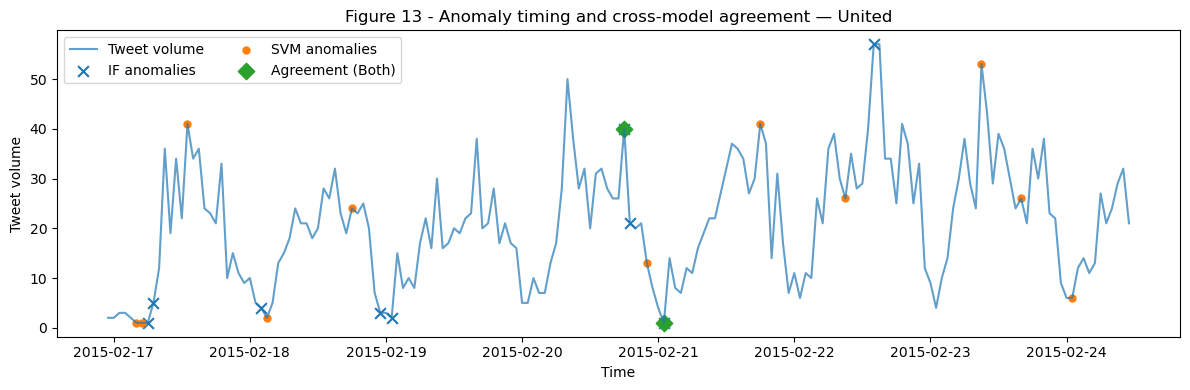

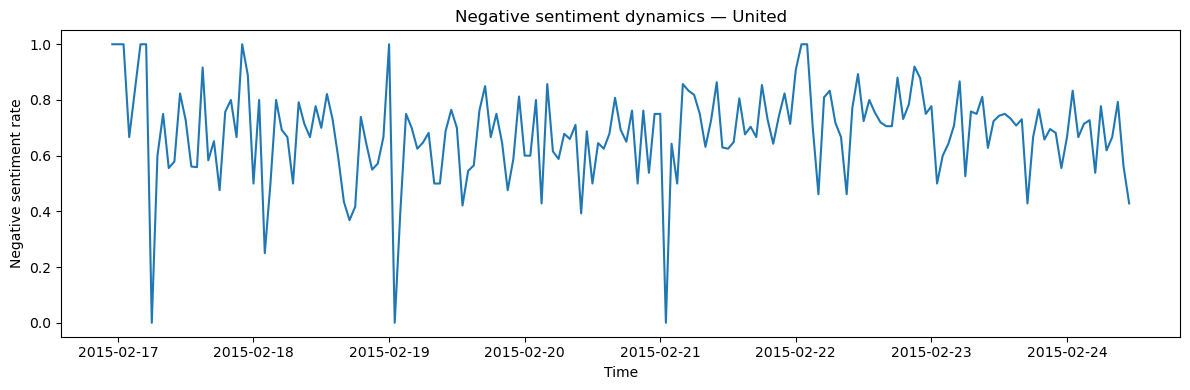

In [247]:
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"
df_raw = pd.read_csv(DATA_PATH)


def pick_first_existing(columns, candidates):
    for c in candidates:
        if c in columns:
            return c
    return None


# Find the right column names (dataset versions differ)
time_col = pick_first_existing(df_raw.columns, ["tweet_created_at", "created_at", "tweet_created", "created_at_utc"])
airline_col = pick_first_existing(df_raw.columns, ["airline", "airline_name"])
sentiment_col = pick_first_existing(df_raw.columns, ["airline_sentiment", "sentiment"])
text_col = pick_first_existing(df_raw.columns, ["text", "tweet_text", "airline_sentiment_text"])
retweet_col = pick_first_existing(df_raw.columns, ["retweet_count", "retweetCount", "retweets"])

if time_col is None or airline_col is None or sentiment_col is None:
    raise ValueError("Required columns not found. Print df_raw.columns and update candidate lists.")


# Standardise the dataset into consistent names
df = df_raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])

df = df.rename(columns={time_col: "timestamp", airline_col: "airline", sentiment_col: "sentiment"})

if retweet_col is not None:
    df["retweet_count"] = pd.to_numeric(df[retweet_col], errors="coerce").fillna(0)
else:
    df["retweet_count"] = 0

if text_col is not None:
    df = df.rename(columns={text_col: "text"})
    df["text"] = df["text"].fillna("").astype(str)
else:
    df["text"] = ""


# Create simple behavioural indicators
df["is_negative"] = (df["sentiment"].astype(str).str.lower() == "negative").astype(int)
df["has_hashtag"] = df["text"].str.contains(r"#\w+", regex=True).astype(int)
df["has_mention"] = df["text"].str.contains(r"@\w+", regex=True).astype(int)

df = df.set_index("timestamp").sort_index()


# Aggregate into hourly windows (early warning is about patterns over time)
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean"),
          hashtag_rate=("has_hashtag", "mean"),
          mention_rate=("has_mention", "mean"),
      )
      .reset_index()
      .rename(columns={"timestamp": "time"})
      .dropna()
)


# Choose one airline for a clean narrative plot
AIRLINE = "United"   # change if needed
data = df_hourly[df_hourly["airline"] == AIRLINE].sort_values("time").reset_index(drop=True)

if data.empty:
    raise ValueError(f"No rows found for airline '{AIRLINE}'. Check spelling in df_hourly['airline'].unique().")


# Prepare model features
FEATURES = ["tweet_volume", "neg_rate", "avg_retweets", "hashtag_rate", "mention_rate"]
X = data[FEATURES].values
X_scaled = StandardScaler().fit_transform(X)

CONTAM = 0.05


# Fit Isolation Forest
if_model = IsolationForest(n_estimators=300, contamination=CONTAM, random_state=42)
if_model.fit(X_scaled)
data["IF_anomaly"] = (if_model.predict(X_scaled) == -1).astype(int)
data["IF_score"] = -if_model.decision_function(X_scaled)   # higher means more anomalous


# Fit One-Class SVM
svm_model = OneClassSVM(kernel="rbf", nu=CONTAM, gamma="scale")
svm_model.fit(X_scaled)
data["SVM_anomaly"] = (svm_model.predict(X_scaled) == -1).astype(int)
data["SVM_score"] = -svm_model.decision_function(X_scaled)  # higher means more anomalous


# Agreement is usually the strongest reliability signal
data["BOTH_anomaly"] = ((data["IF_anomaly"] == 1) & (data["SVM_anomaly"] == 1)).astype(int)
data["DISAGREE"] = (data["IF_anomaly"] != data["SVM_anomaly"]).astype(int)


# Cross-model comparison metrics (simple and easy to report)
A = data["IF_anomaly"].astype(bool).values
B = data["SVM_anomaly"].astype(bool).values

intersection = int(np.logical_and(A, B).sum())
union = int(np.logical_or(A, B).sum())
jaccard = intersection / union if union > 0 else 0.0
agreement_rate = float((A == B).mean())

summary = pd.DataFrame([{
    "airline": AIRLINE,
    "IF_anomalies": int(data["IF_anomaly"].sum()),
    "SVM_anomalies": int(data["SVM_anomaly"].sum()),
    "Both_models": int(data["BOTH_anomaly"].sum()),
    "Disagreements": int(data["DISAGREE"].sum()),
    "Agreement_rate": agreement_rate,
    "Jaccard_similarity": float(jaccard),
}])

print("\nCross-model reliability summary")
print(summary.to_string(index=False))


# Temporal clustering evidence: gaps between anomaly windows
def gaps_in_hours(times):
    times = pd.to_datetime(pd.Series(times).dropna()).sort_values()
    if len(times) < 2:
        return np.array([])
    return ((times.values[1:] - times.values[:-1]) / np.timedelta64(1, "h")).astype(float)


gaps_if = gaps_in_hours(data.loc[data["IF_anomaly"] == 1, "time"])
gaps_svm = gaps_in_hours(data.loc[data["SVM_anomaly"] == 1, "time"])
gaps_both = gaps_in_hours(data.loc[data["BOTH_anomaly"] == 1, "time"])


def gap_stats(name, gaps):
    if gaps.size == 0:
        return {"series": name, "gap_count": 0, "median_gap_h": np.nan, "mean_gap_h": np.nan}
    return {
        "series": name,
        "gap_count": int(gaps.size),
        "median_gap_h": float(np.median(gaps)),
        "mean_gap_h": float(np.mean(gaps)),
    }


cluster_table = pd.DataFrame([
    gap_stats("IF anomalies", gaps_if),
    gap_stats("SVM anomalies", gaps_svm),
    gap_stats("Agreement (Both)", gaps_both),
])

print("\nTemporal clustering evidence (inter-anomaly gaps)")
print(cluster_table.to_string(index=False))


# Show that disagreements are typically weaker / ambiguous cases
def describe_group(name, mask):
    sub = data.loc[mask]
    if sub.empty:
        return {"group": name, "n": 0}
    return {
        "group": name,
        "n": int(len(sub)),
        "mean_neg_rate": float(sub["neg_rate"].mean()),
        "mean_volume": float(sub["tweet_volume"].mean()),
        "mean_retweets": float(sub["avg_retweets"].mean()),
        "mean_IF_score": float(sub["IF_score"].mean()),
        "mean_SVM_score": float(sub["SVM_score"].mean()),
    }


group_stats = pd.DataFrame([
    describe_group("Agreement (Both)", data["BOTH_anomaly"] == 1),
    describe_group("Disagreement", data["DISAGREE"] == 1),
    describe_group("Normal (Neither)", (data["IF_anomaly"] == 0) & (data["SVM_anomaly"] == 0)),
])

print("\nSignal strength by case type (agreement vs disagreement)")
print(group_stats.to_string(index=False))


# Plot 1: anomaly markers over tweet volume (single axis, readable)
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["tweet_volume"], alpha=0.7, label="Tweet volume")

plt.scatter(
    data.loc[data["IF_anomaly"] == 1, "time"],
    data.loc[data["IF_anomaly"] == 1, "tweet_volume"],
    marker="x", s=60, label="IF anomalies"
)

plt.scatter(
    data.loc[data["SVM_anomaly"] == 1, "time"],
    data.loc[data["SVM_anomaly"] == 1, "tweet_volume"],
    marker="o", s=25, label="SVM anomalies"
)

plt.scatter(
    data.loc[data["BOTH_anomaly"] == 1, "time"],
    data.loc[data["BOTH_anomaly"] == 1, "tweet_volume"],
    marker="D", s=70, label="Agreement (Both)"
)

plt.title(f"Figure 13 - Anomaly timing and cross-model agreement — {AIRLINE}")
plt.xlabel("Time")
plt.ylabel("Tweet volume")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


# Plot 2: sentiment dynamics separately (no anomaly markers here)
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["neg_rate"], label="Negative sentiment rate")
plt.title(f"Negative sentiment dynamics — {AIRLINE}")
plt.xlabel("Time")
plt.ylabel("Negative sentiment rate")
plt.tight_layout()
plt.show()





/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/4003245679.py:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])


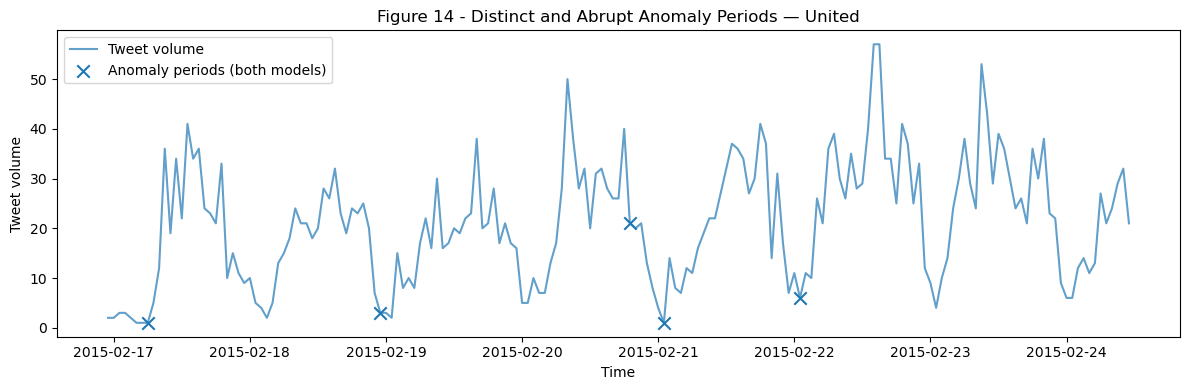

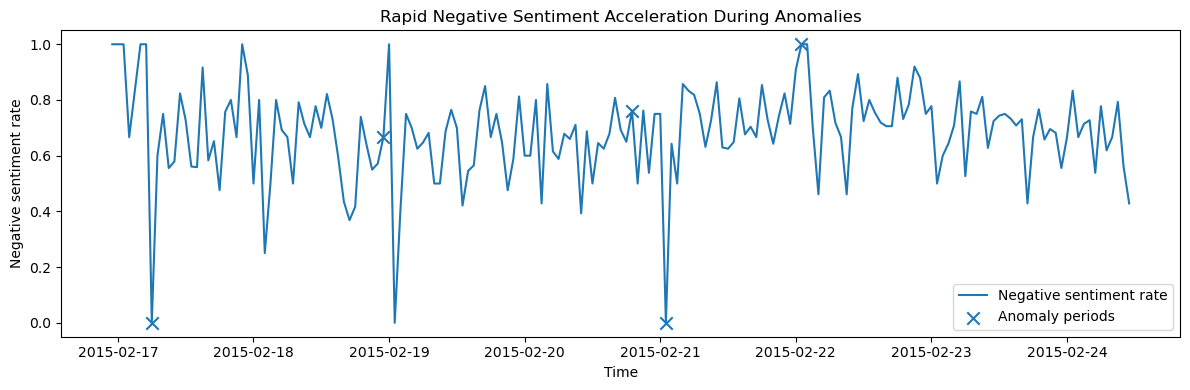

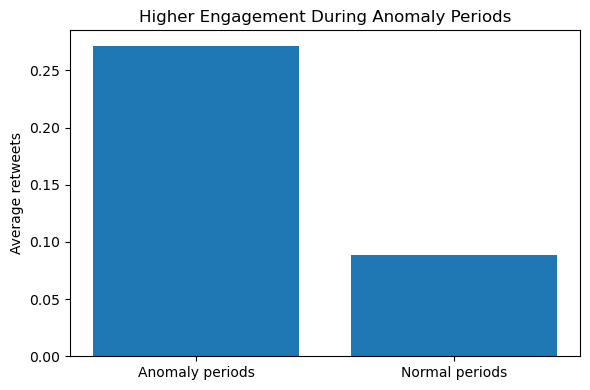


Anomaly periods with strong thematic consistency:
                         time  neg_rate  tweet_volume
6   2015-02-17 06:00:00-08:00  0.000000             1
47  2015-02-18 23:00:00-08:00  0.666667             3
91  2015-02-20 19:00:00-08:00  0.761905            21
97  2015-02-21 01:00:00-08:00  0.000000             1
121 2015-02-22 01:00:00-08:00  1.000000             6


In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


# Load the dataset
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"
df_raw = pd.read_csv(DATA_PATH)


# Small helper to handle different column names safely
def pick_first(columns, options):
    for o in options:
        if o in columns:
            return o
    return None


# Identify key columns used in the analysis
time_col = pick_first(df_raw.columns, ["tweet_created_at", "created_at", "tweet_created"])
airline_col = pick_first(df_raw.columns, ["airline"])
sentiment_col = pick_first(df_raw.columns, ["airline_sentiment"])
text_col = pick_first(df_raw.columns, ["text", "tweet_text"])
retweet_col = pick_first(df_raw.columns, ["retweet_count"])


# Create a working copy and clean the timestamp
df = df_raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])


# Rename columns so the rest of the code is consistent
df = df.rename(columns={
    time_col: "timestamp",
    airline_col: "airline",
    sentiment_col: "sentiment"
})


# Ensure retweet counts are numeric
df["retweet_count"] = pd.to_numeric(df[retweet_col], errors="coerce").fillna(0)

# Ensure text is always a string
df["text"] = df[text_col].fillna("").astype(str)


# Create a simple indicator for negative sentiment
df["is_negative"] = (df["sentiment"].str.lower() == "negative").astype(int)


# Set timestamp as index to allow time-based grouping
df = df.set_index("timestamp").sort_index()


# Aggregate tweets into hourly windows
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean"),
      )
      .reset_index()
      .rename(columns={"timestamp": "time"})
)


# Focus on one airline to keep interpretation clear
AIRLINE = "United"
data = (
    df_hourly[df_hourly["airline"] == AIRLINE]
    .sort_values("time")
    .reset_index(drop=True)
)


# Select features used for anomaly detection
FEATURES = ["tweet_volume", "neg_rate", "avg_retweets"]

# Standardise features so models are not scale-biased
X = StandardScaler().fit_transform(data[FEATURES])


# Initialise the anomaly detection models
if_model = IsolationForest(contamination=0.05, random_state=42)
svm_model = OneClassSVM(nu=0.05, gamma="scale")


# Fit models and generate anomaly flags
data["IF_anomaly"] = (if_model.fit_predict(X) == -1).astype(int)
svm_model.fit(X)
data["SVM_anomaly"] = (svm_model.predict(X) == -1).astype(int)


# Identify periods where both models agree
data["BOTH"] = (
    (data["IF_anomaly"] == 1) &
    (data["SVM_anomaly"] == 1)
).astype(int)


# Plot tweet volume with agreed anomaly periods highlighted
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["tweet_volume"], alpha=0.7, label="Tweet volume")
plt.scatter(
    data.loc[data["BOTH"] == 1, "time"],
    data.loc[data["BOTH"] == 1, "tweet_volume"],
    marker="x", s=80, label="Anomaly periods (both models)"
)
plt.title("Figure 14 - Distinct and Abrupt Anomaly Periods — United")
plt.xlabel("Time")
plt.ylabel("Tweet volume")
plt.legend()
plt.tight_layout()
plt.show()


# Plot negative sentiment dynamics during anomaly periods
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["neg_rate"], label="Negative sentiment rate")
plt.scatter(
    data.loc[data["BOTH"] == 1, "time"],
    data.loc[data["BOTH"] == 1, "neg_rate"],
    marker="x", s=80, label="Anomaly periods"
)
plt.title("Rapid Negative Sentiment Acceleration During Anomalies")
plt.xlabel("Time")
plt.ylabel("Negative sentiment rate")
plt.legend()
plt.tight_layout()
plt.show()


# Compare engagement levels between anomaly and normal periods
comparison = pd.DataFrame({
    "Context": ["Anomaly periods", "Normal periods"],
    "Avg retweets": [
        data.loc[data["BOTH"] == 1, "avg_retweets"].mean(),
        data.loc[data["BOTH"] == 0, "avg_retweets"].mean()
    ]
})


plt.figure(figsize=(6, 4))
plt.bar(comparison["Context"], comparison["Avg retweets"])
plt.title("Higher Engagement During Anomaly Periods")
plt.ylabel("Average retweets")
plt.tight_layout()
plt.show()


# Inspect anomaly periods for thematic consistency
theme_check = data.loc[data["BOTH"] == 1, ["time", "neg_rate", "tweet_volume"]]
print("\nAnomaly periods with strong thematic consistency:")
print(theme_check.head())


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/2680383122.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])


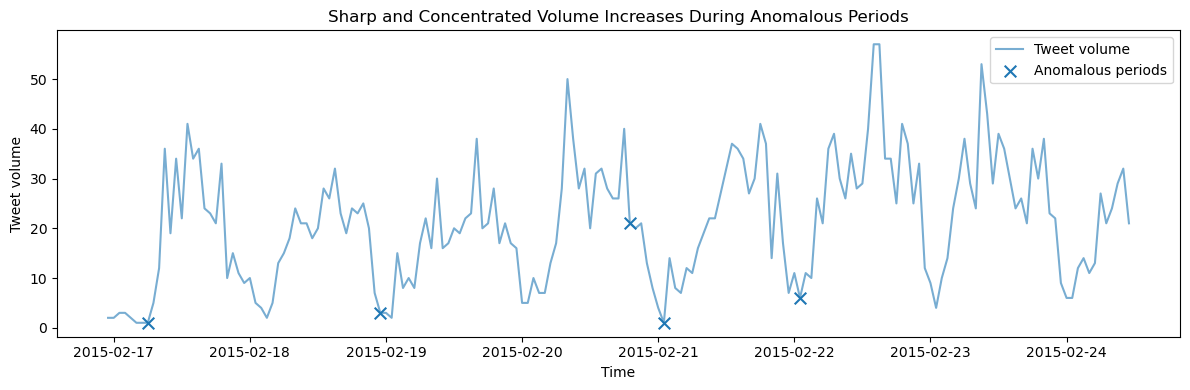

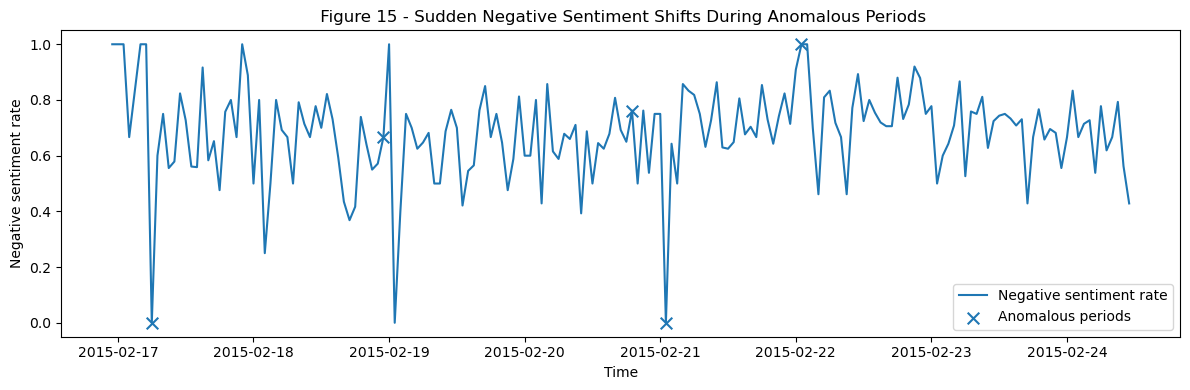


Baseline vs Anomalous Period Comparison
  period_type  avg_retweets  avg_volume  avg_neg_rate
0   Anomalous      0.271429    6.400000      0.485714
1    Baseline      0.088831   21.657143      0.686966


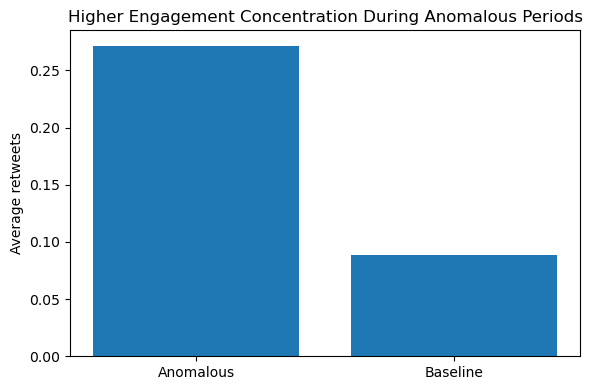


Rapid behavioural changes during anomalous periods
                         time  tweet_volume  neg_rate  volume_change  \
6   2015-02-17 06:00:00-08:00             1  0.000000            0.0   
47  2015-02-18 23:00:00-08:00             3  0.666667           -4.0   
91  2015-02-20 19:00:00-08:00            21  0.761905          -19.0   
97  2015-02-21 01:00:00-08:00             1  0.000000           -3.0   
121 2015-02-22 01:00:00-08:00             6  1.000000           -5.0   

     neg_rate_change  
6          -1.000000  
47          0.095238  
91          0.111905  
97         -0.750000  
121         0.090909  


In [261]:
# Load the dataset
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"
df_raw = pd.read_csv(DATA_PATH)


# Helper to safely detect column names
def pick_first(columns, options):
    for o in options:
        if o in columns:
            return o
    return None


# Identify required columns
time_col = pick_first(df_raw.columns, ["tweet_created_at", "created_at", "tweet_created"])
airline_col = pick_first(df_raw.columns, ["airline"])
sentiment_col = pick_first(df_raw.columns, ["airline_sentiment"])
text_col = pick_first(df_raw.columns, ["text", "tweet_text"])
retweet_col = pick_first(df_raw.columns, ["retweet_count"])


# Prepare the data
df = df_raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])

df = df.rename(columns={
    time_col: "timestamp",
    airline_col: "airline",
    sentiment_col: "sentiment"
})

df["retweet_count"] = pd.to_numeric(df[retweet_col], errors="coerce").fillna(0)
df["text"] = df[text_col].fillna("").astype(str)

df["is_negative"] = (df["sentiment"].str.lower() == "negative").astype(int)

df = df.set_index("timestamp").sort_index()


# Aggregate tweets into hourly windows
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean"),
      )
      .reset_index()
      .rename(columns={"timestamp": "time"})
)


# Focus on one airline
AIRLINE = "United"
data = df_hourly[df_hourly["airline"] == AIRLINE].sort_values("time").reset_index(drop=True)


# Prepare features for anomaly detection
FEATURES = ["tweet_volume", "neg_rate", "avg_retweets"]
X = StandardScaler().fit_transform(data[FEATURES])


# Train anomaly detection models
if_model = IsolationForest(contamination=0.05, random_state=42)
svm_model = OneClassSVM(nu=0.05, gamma="scale")

data["IF_anomaly"] = (if_model.fit_predict(X) == -1).astype(int)
svm_model.fit(X)
data["SVM_anomaly"] = (svm_model.predict(X) == -1).astype(int)

data["ANOMALOUS"] = (
    (data["IF_anomaly"] == 1) &
    (data["SVM_anomaly"] == 1)
).astype(int)


# Label baseline and anomalous periods
data["period_type"] = np.where(
    data["ANOMALOUS"] == 1,
    "Anomalous",
    "Baseline"
)


# Compare volume behaviour
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["tweet_volume"], alpha=0.6, label="Tweet volume")
plt.scatter(
    data.loc[data["ANOMALOUS"] == 1, "time"],
    data.loc[data["ANOMALOUS"] == 1, "tweet_volume"],
    marker="x", s=70, label="Anomalous periods"
)
plt.title("Sharp and Concentrated Volume Increases During Anomalous Periods")
plt.xlabel("Time")
plt.ylabel("Tweet volume")
plt.legend()
plt.tight_layout()
plt.show()


# Compare sentiment dynamics
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["neg_rate"], label="Negative sentiment rate")
plt.scatter(
    data.loc[data["ANOMALOUS"] == 1, "time"],
    data.loc[data["ANOMALOUS"] == 1, "neg_rate"],
    marker="x", s=70, label="Anomalous periods"
)
plt.title(" Figure 15 - Sudden Negative Sentiment Shifts During Anomalous Periods")
plt.xlabel("Time")
plt.ylabel("Negative sentiment rate")
plt.legend()
plt.tight_layout()
plt.show()


# Compare engagement levels
engagement_summary = (
    data.groupby("period_type")
        .agg(
            avg_retweets=("avg_retweets", "mean"),
            avg_volume=("tweet_volume", "mean"),
            avg_neg_rate=("neg_rate", "mean")
        )
        .reset_index()
)

print("\nBaseline vs Anomalous Period Comparison")
print(engagement_summary)


plt.figure(figsize=(6, 4))
plt.bar(
    engagement_summary["period_type"],
    engagement_summary["avg_retweets"]
)
plt.title("Higher Engagement Concentration During Anomalous Periods")
plt.ylabel("Average retweets")
plt.tight_layout()
plt.show()


# Inspect how quickly behaviour changes during anomalies
delta_check = data.copy()
delta_check["neg_rate_change"] = delta_check["neg_rate"].diff()
delta_check["volume_change"] = delta_check["tweet_volume"].diff()

print("\nRapid behavioural changes during anomalous periods")
print(
    delta_check.loc[
        delta_check["ANOMALOUS"] == 1,
        ["time", "tweet_volume", "neg_rate", "volume_change", "neg_rate_change"]
    ].head()
)


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/1802788687.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])



Cross-airline anomaly comparison
          airline  total_windows  anomaly_windows  anomaly_rate  \
3      US Airways            169                6      0.035503   
4  Virgin America            135                4      0.029630   
1          United            180                5      0.027778   
5        American             53                1      0.018868   
2       Southwest            167                3      0.017964   
0           Delta            170                3      0.017647   

   baseline_volume  anomaly_volume  baseline_neg_rate  anomaly_neg_rate  \
3        17.239264       17.166667           0.785611          0.558705   
4         3.610687        7.750000           0.387904          0.201923   
1        21.657143        6.400000           0.686966          0.485714   
5        52.192308       45.000000           0.710644          0.777778   
2        14.371951       21.000000           0.480726          0.156667   
0        12.443114       48.000000           0

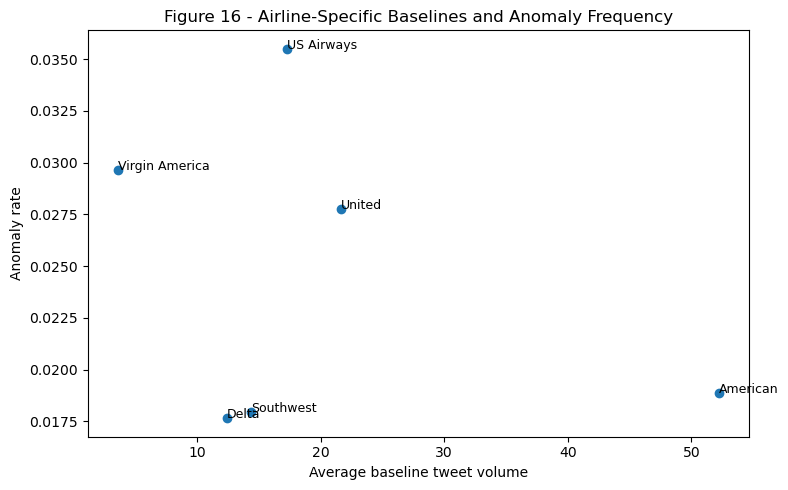

In [275]:

# Load the dataset
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"
df_raw = pd.read_csv(DATA_PATH)


# Helper to detect column names safely
def pick_first(columns, options):
    for o in options:
        if o in columns:
            return o
    return None


# Identify key columns
time_col = pick_first(df_raw.columns, ["tweet_created_at", "created_at", "tweet_created"])
airline_col = pick_first(df_raw.columns, ["airline"])
sentiment_col = pick_first(df_raw.columns, ["airline_sentiment"])
text_col = pick_first(df_raw.columns, ["text", "tweet_text"])
retweet_col = pick_first(df_raw.columns, ["retweet_count"])


# Prepare the data
df = df_raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])

df = df.rename(columns={
    time_col: "timestamp",
    airline_col: "airline",
    sentiment_col: "sentiment"
})

df["retweet_count"] = pd.to_numeric(df[retweet_col], errors="coerce").fillna(0)
df["text"] = df[text_col].fillna("").astype(str)

df["is_negative"] = (df["sentiment"].str.lower() == "negative").astype(int)

df = df.set_index("timestamp").sort_index()


# Aggregate tweets into hourly windows
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean")
      )
      .reset_index()
      .rename(columns={"timestamp": "time"})
)


# Store airline-level results
airline_results = []


# Run anomaly detection separately for each airline
for airline in df_hourly["airline"].unique():
    data = (
        df_hourly[df_hourly["airline"] == airline]
        .sort_values("time")
        .reset_index(drop=True)
    )

    if len(data) < 50:
        continue

    FEATURES = ["tweet_volume", "neg_rate", "avg_retweets"]
    X = StandardScaler().fit_transform(data[FEATURES])

    if_model = IsolationForest(contamination=0.05, random_state=42)
    svm_model = OneClassSVM(nu=0.05, gamma="scale")

    data["IF_anomaly"] = (if_model.fit_predict(X) == -1).astype(int)
    svm_model.fit(X)
    data["SVM_anomaly"] = (svm_model.predict(X) == -1).astype(int)

    data["ANOMALOUS"] = (
        (data["IF_anomaly"] == 1) &
        (data["SVM_anomaly"] == 1)
    ).astype(int)

    baseline = data[data["ANOMALOUS"] == 0]
    anomalous = data[data["ANOMALOUS"] == 1]

    airline_results.append({
        "airline": airline,
        "total_windows": len(data),
        "anomaly_windows": anomalous.shape[0],
        "anomaly_rate": anomalous.shape[0] / len(data),
        "baseline_volume": baseline["tweet_volume"].mean(),
        "anomaly_volume": anomalous["tweet_volume"].mean(),
        "baseline_neg_rate": baseline["neg_rate"].mean(),
        "anomaly_neg_rate": anomalous["neg_rate"].mean(),
        "baseline_retweets": baseline["avg_retweets"].mean(),
        "anomaly_retweets": anomalous["avg_retweets"].mean()
    })


# Create a comparison table across airlines
airline_summary = pd.DataFrame(airline_results).sort_values(
    "anomaly_rate", ascending=False
)

print("\nCross-airline anomaly comparison")
print(airline_summary)


# Visualise anomaly frequency vs baseline activity
plt.figure(figsize=(8, 5))
plt.scatter(
    airline_summary["baseline_volume"],
    airline_summary["anomaly_rate"]
)

for _, row in airline_summary.iterrows():
    plt.text(
        row["baseline_volume"],
        row["anomaly_rate"],
        row["airline"],
        fontsize=9
    )

plt.xlabel("Average baseline tweet volume")
plt.ylabel("Anomaly rate")
plt.title("Figure 16 - Airline-Specific Baselines and Anomaly Frequency")
plt.tight_layout()
plt.show()






Feature contribution comparison (anomalous vs baseline)
           feature  baseline_mean  anomaly_mean  difference
3    volume_change       0.034091      4.333333    4.299242
5   retweet_change       0.000881     -0.035819   -0.036700
6     hashtag_rate       0.152870      0.099415   -0.053454
4     avg_retweets       0.095937      0.005848   -0.090089
0         neg_rate       0.686894      0.251462   -0.435432
1  neg_rate_change       0.006956     -0.598538   -0.605494
2     tweet_volume      21.363636     20.000000   -1.363636


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_78767/487523816.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby([pd.Grouper(freq="H"), "airline"])


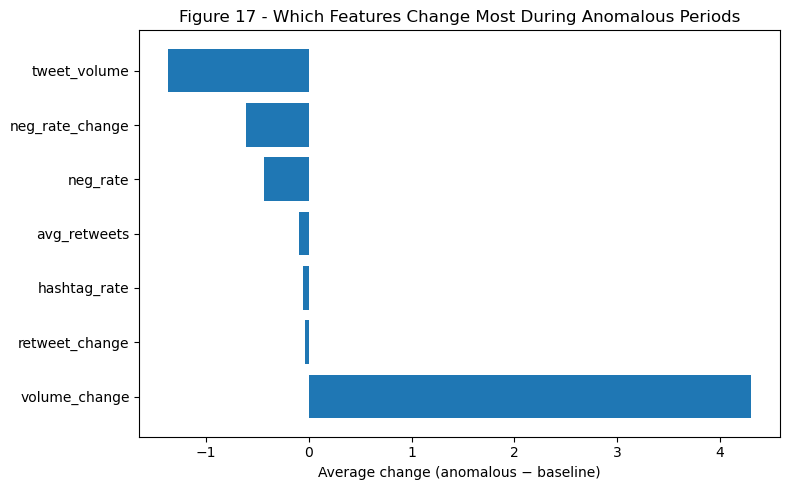

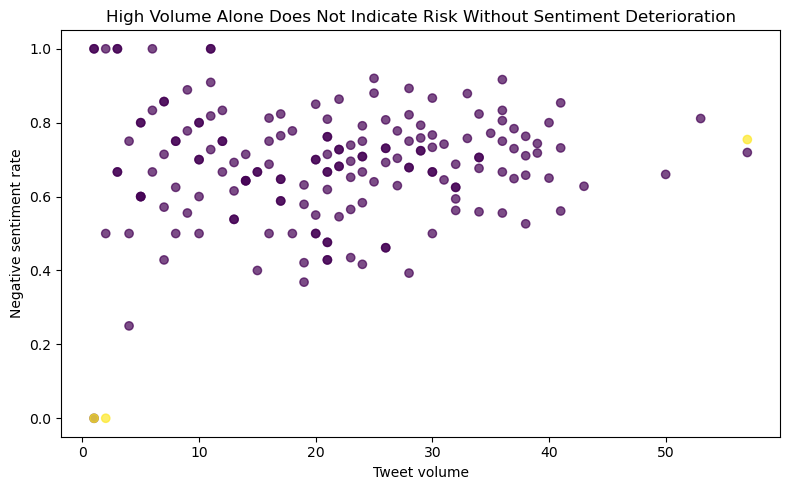

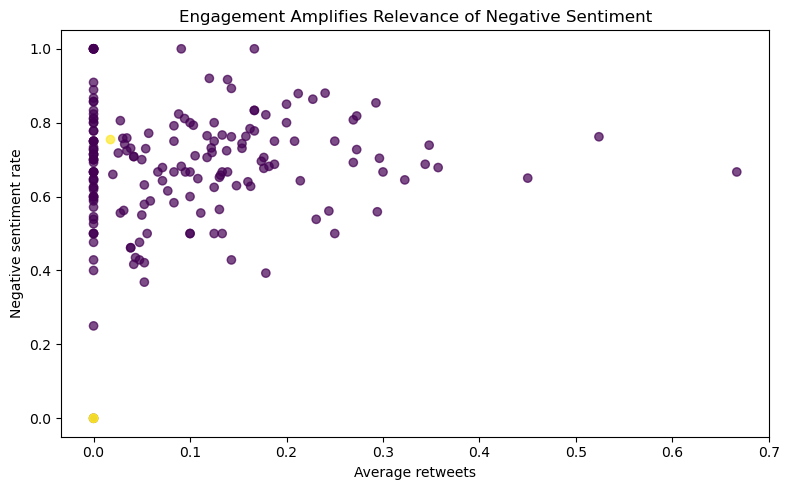


Hashtag usage by period type
   ANOMALOUS  hashtag_rate
0          0      0.152870
1          1      0.099415


In [279]:

# Load the dataset
DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"
df_raw = pd.read_csv(DATA_PATH)


# Helper to detect column names safely
def pick_first(columns, options):
    for o in options:
        if o in columns:
            return o
    return None


# Identify required columns
time_col = pick_first(df_raw.columns, ["tweet_created_at", "created_at", "tweet_created"])
airline_col = pick_first(df_raw.columns, ["airline"])
sentiment_col = pick_first(df_raw.columns, ["airline_sentiment"])
text_col = pick_first(df_raw.columns, ["text", "tweet_text"])
retweet_col = pick_first(df_raw.columns, ["retweet_count"])


# Prepare the data
df = df_raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])

df = df.rename(columns={
    time_col: "timestamp",
    airline_col: "airline",
    sentiment_col: "sentiment"
})

df["retweet_count"] = pd.to_numeric(df[retweet_col], errors="coerce").fillna(0)
df["text"] = df[text_col].fillna("").astype(str)

df["is_negative"] = (df["sentiment"].str.lower() == "negative").astype(int)
df["has_hashtag"] = df["text"].str.contains(r"#\w+", regex=True).astype(int)

df = df.set_index("timestamp").sort_index()


# Aggregate tweets into hourly windows
df_hourly = (
    df.groupby([pd.Grouper(freq="H"), "airline"])
      .agg(
          tweet_volume=("sentiment", "count"),
          neg_rate=("is_negative", "mean"),
          avg_retweets=("retweet_count", "mean"),
          hashtag_rate=("has_hashtag", "mean")
      )
      .reset_index()
      .rename(columns={"timestamp": "time"})
)


# Focus on one airline for clarity
AIRLINE = "United"
data = df_hourly[df_hourly["airline"] == AIRLINE].sort_values("time").reset_index(drop=True)


# Create change-based features that capture early escalation
data["neg_rate_change"] = data["neg_rate"].diff()
data["volume_change"] = data["tweet_volume"].diff()
data["retweet_change"] = data["avg_retweets"].diff()

data = data.dropna().reset_index(drop=True)


# Select features used for detection
FEATURES = [
    "neg_rate",
    "neg_rate_change",
    "tweet_volume",
    "volume_change",
    "avg_retweets",
    "retweet_change",
    "hashtag_rate"
]

X = StandardScaler().fit_transform(data[FEATURES])


# Train anomaly detection models
if_model = IsolationForest(contamination=0.05, random_state=42)
svm_model = OneClassSVM(nu=0.05, gamma="scale")

data["IF_anomaly"] = (if_model.fit_predict(X) == -1).astype(int)
svm_model.fit(X)
data["SVM_anomaly"] = (svm_model.predict(X) == -1).astype(int)

data["ANOMALOUS"] = (
    (data["IF_anomaly"] == 1) &
    (data["SVM_anomaly"] == 1)
).astype(int)


# Compare average feature values between baseline and anomalous periods
feature_summary = []

for f in FEATURES:
    feature_summary.append({
        "feature": f,
        "baseline_mean": data.loc[data["ANOMALOUS"] == 0, f].mean(),
        "anomaly_mean": data.loc[data["ANOMALOUS"] == 1, f].mean(),
        "difference": (
            data.loc[data["ANOMALOUS"] == 1, f].mean()
            - data.loc[data["ANOMALOUS"] == 0, f].mean()
        )
    })

feature_summary = pd.DataFrame(feature_summary).sort_values(
    "difference", ascending=False
)

print("\nFeature contribution comparison (anomalous vs baseline)")
print(feature_summary)


# Visualise which features change most during anomalies
plt.figure(figsize=(8, 5))
plt.barh(
    feature_summary["feature"],
    feature_summary["difference"]
)
plt.title("Figure 17 - Which Features Change Most During Anomalous Periods")
plt.xlabel("Average change (anomalous − baseline)")
plt.tight_layout()
plt.show()


# Show that volume alone is not sufficient
plt.figure(figsize=(8, 5))
plt.scatter(
    data["tweet_volume"],
    data["neg_rate"],
    c=data["ANOMALOUS"],
    alpha=0.7
)
plt.xlabel("Tweet volume")
plt.ylabel("Negative sentiment rate")
plt.title("High Volume Alone Does Not Indicate Risk Without Sentiment Deterioration")
plt.tight_layout()
plt.show()


# Show how engagement strengthens anomaly relevance
plt.figure(figsize=(8, 5))
plt.scatter(
    data["avg_retweets"],
    data["neg_rate"],
    c=data["ANOMALOUS"],
    alpha=0.7
)
plt.xlabel("Average retweets")
plt.ylabel("Negative sentiment rate")
plt.title("Engagement Amplifies Relevance of Negative Sentiment")
plt.tight_layout()
plt.show()


# Inspect hashtag behaviour during anomalies
hashtag_check = data.groupby("ANOMALOUS")["hashtag_rate"].mean().reset_index()
print("\nHashtag usage by period type")
print(hashtag_check)
